In [1]:
#Install
#!pip install numpy matplotlib torch tqdm requests torchvision transformers

# Standard Libraries for file and operating system operations, security, and web requests
import os
import hashlib
import requests
import random
import gc

# Core Python Data Science and Visualization Libraries
import numpy as np
import scipy
from matplotlib import pyplot as plt
import logging

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torch.cuda.amp import autocast, GradScaler
from torch.autograd import profiler

# Additional Utilities
import tqdm

In [2]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle") # update this to match your course

In [3]:
# @title Plotting functions

def plot_inputs_over_time(timesteps, avg_inputs):
    """
    Plot the average inputs over time to visualize changes in input values.
    
    Args:
    - timesteps (list or array-like): A sequence of time steps at which the inputs were recorded.
      This acts as the x-axis in the plot, representing the progression of time.
    - avg_inputs (list or array-like): The average values of inputs corresponding to each time step. 
      These values are plotted on the y-axis, showing the magnitude of inputs over time.
    
    Returns:
    This function generates and displays a plot using Matplotlib. The plot is displayed
    in the output area of the Jupyter notebook or Python script execution environment. It shows the progression of
    average input values over the specified time steps.
    """
    
    plt.figure(figsize=(12, 4))
    plt.plot(timesteps, avg_inputs, label='Inputs')
    plt.title('Inputs over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Average Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_muscles_over_time(timesteps, avg_output):
    """
    Plot the average outputs over time to visualize changes in output values.
    
    Args:
    - timesteps (list or array-like): A sequence of time steps at which the outputs were recorded.
      This acts as the x-axis in the plot, representing the progression of time.
    - avg_outputs (list or array-like): The average values of outputs corresponding to each time step. 
      These values are plotted on the y-axis, showing the magnitude of outputs over time.
    
    Returns:
    This function generates and displays a plot using Matplotlib. The plot is displayed
    in the output area of the Jupyter notebook or Python script execution environment. It shows the progression of
    average output values over the specified time steps.
    """
    plt.figure(figsize=(12, 4))
    plt.plot(timesteps, avg_output, label='Muscle')
    plt.title('Muscles over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Average Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_training_validation_losses(epoch_losses, val_losses, actual_num_epochs, title):
    """
    This function plots the training and validation losses over epochs. 

    Args:
        epoch_losses (list of float): List containing the training loss for each epoch. Each element is a float
            representing the loss calculated after each epoch of training.
        val_losses (list of float): List containing the validation loss for each epoch. Similar to `epoch_losses`, but
            for the validation set, allowing for the comparison between training and validation performance.
        actual_num_epochs (int): The actual number of epochs the training went through. This could be different from
            the initially set number of epochs if early stopping was employed. It determines the range of the x-axis
            in the plot.
        title (str): A string that sets the title of the plot. This allows for customization of the plot for better
            readability and interpretation.

    Returns:
        This function generates and displays a plot using matplotlib.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, actual_num_epochs + 1), epoch_losses, label='Training Loss')
    plt.plot(range(1, actual_num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)  
    plt.legend()
    plt.show()


def plot_psth(data, title, bin_size=10):
    """
    This function takes neural data, averages it across conditions
    and time delays for each time bin, and plots the averaged neural activity for each feature
    across time bins.

    Args:
        data (Tensor): A 4D tensor containing the neural data with dimensions corresponding to
                       [conditions, delays, time, features], where 'conditions' could be different
                       stimulus conditions, 'delays' are different time delays after the stimulus,
                       'time' is the time dimension, and 'features' represent different neurons or
                       recorded channels.
        title (str): The title for the PSTH plot. This allows users to specify the context or the
                     experiment from which the data is derived.
        bin_size (int, optional): The size of the time bins in units of the 'time' dimension. This
                                  parameter allows the user to specify how much temporal data should
                                  be averaged together to calculate the mean activity. Default is 10.

    This function directly generates and displays a plot using matplotlib
    to visually represent the averaged neural activity across time bins for each feature.
    """
    # Averaging neural activity across conditions, delays for each time bin
    mean_data = data.mean(dim=(0, 1))  # Mean across conditions and delays

    # Number of bins
    n_bins = mean_data.shape[0] // bin_size

    # Prepare the data for plotting
    binned_data = mean_data[:n_bins*bin_size].unfold(0, bin_size, bin_size).mean(dim=2)

    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(binned_data.shape[1]):  # Iterate over each feature/channel
        plt.plot(binned_data[:, i], label=f'Feature {i+1}')
    plt.xlabel('Time (bins)')
    plt.ylabel('Average Activity')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_hidden_unit_activations(hidden_states, timesteps, neurons_to_plot=5, title='PSTHs of Hidden Units'):
    """
    This function plots the average activation of a specified number of neurons from the hidden layers 
    of a neural network over a certain number of timesteps. 
    
    Args:
        hidden_states (np.ndarray): A 3D numpy array containing the hidden states of a network. The dimensions
                                     should be (time, batch, features), where 'time' represents the sequence of 
                                     timesteps, 'batch' represents different data samples, and 'features' represents
                                     the neuron activations or features at each timestep.
        timesteps (int): The number of timesteps to consider from the end of the hidden states array. This allows 
                         focusing on the recent activity by looking at the last 'timesteps' number of steps.
        neurons_to_plot (int, optional): The number of neuron activations to plot, starting from the first neuron.
                                         Defaults to 5.
        title (str, optional): The title of the plot, allowing customization for specific analyses or presentations.
                               Defaults to 'PSTHs of Hidden Units'.

    This function generates and displays a plot of the average activation of specified
    neurons over the selected timesteps, providing a visual analysis of neuron behavior within the network.
    """
    # Slicing to take only the last 'timesteps' timesteps
    last_hidden_states = hidden_states[-timesteps:]
    
    # Apply the nonlinearity to each hidden state before averaging
    rectified_tanh = lambda x: np.where(x > 0, np.tanh(x), 0)
    hidden_states_rectified = rectified_tanh(np.array(last_hidden_states))
    
    # Calculate the mean across all batches for each time step
    mean_activations = np.mean(hidden_states_rectified, axis=1)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    for i in range(min(neurons_to_plot, hidden_states_rectified.shape[2])):
        plt.plot(range(timesteps), mean_activations[:, i], label=f'Neuron {i+1}')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Average Activation')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_perturbation_results(perturbation_strengths, results_simple, results_complex, title):
    """
    This function plots the normalized error percentages of two models (simple and complex) under various 
    perturbation strengths. 

    Args:
        perturbation_strengths (list of float): A list of perturbation strengths tested, representing the 
                                                 magnitude of perturbations applied to the model input or parameters.
        results_simple (list of tuples): Each tuple contains (mean error, standard deviation) for the simple model
                                         at each perturbation strength.
        results_complex (list of tuples): Each tuple contains (mean error, standard deviation) for the complex model
                                          at each perturbation strength.
        title (str): The title of the plot, allowing for customization to reflect the analysis context.

    The function generates and displays a bar plot comparing the normalized error 
    rates of simple and complex models under different perturbation strengths, with error bars representing the 
    standard deviation of errors, normalized to percentage scale.
    """
    mean_errors_simple, std_errors_simple = zip(*results_simple)
    mean_errors_complex, std_errors_complex = zip(*results_complex)

    # Normalizing errors and standard deviations
    max_error_simple = max(mean_errors_simple)
    max_error_complex = max(mean_errors_complex)

    print("SimpleRNN: mean errors", mean_errors_simple)
    print("ComplicatedRNN: mean errors", mean_errors_complex)
    
    normalized_mean_errors_simple = [(x / max_error_simple) * 100 for x in mean_errors_simple]
    normalized_mean_errors_complex = [(x / max_error_complex) * 100 for x in mean_errors_complex]
    normalized_std_errors_simple = [(y / max_error_simple) * 100 for y in std_errors_simple]
    normalized_std_errors_complex = [(y / max_error_complex) * 100 for y in std_errors_complex]

    print("SimpleRNN: normalised mean errors", normalized_mean_errors_simple)
    print("ComplicatedRNN: normalised mean errors", normalized_mean_errors_complex)

    # Plotting
    plt.figure(figsize=(10, 7))
    bar_width = 0.35
    bar_positions = np.arange(len(perturbation_strengths))

    plt.bar(bar_positions - bar_width/2, normalized_mean_errors_simple, width=bar_width, color='blue', yerr=normalized_std_errors_simple, capsize=5, label='Simple Model')
    plt.bar(bar_positions + bar_width/2, normalized_mean_errors_complex, width=bar_width, color='red', yerr=normalized_std_errors_complex, capsize=5, label='Complex Model')

    plt.xlabel('Perturbation Magnitude')
    plt.ylabel('Normalized Error (%)')
    plt.title(title)
    plt.xticks(bar_positions, [f"{x:.5f}" if x < 0.1 else f"{x}" for x in perturbation_strengths])
    plt.legend()
    plt.ylim(0, 100)
    plt.show()


In [4]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
    """
    Determines and sets the computational device for PyTorch operations based on the availability of a CUDA-capable GPU.
    
    Returns:
        str: The device that PyTorch will use for computations ('cuda' or 'cpu'). This string can be directly used
             in PyTorch operations to specify the device.
    """
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled in this notebook. \n"
              "If you want to enable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `GPU` from the dropdown menu")
    else:
        print("GPU is enabled in this notebook. \n"
              "If you want to disable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `None` from the dropdown menu")

    return device

In [5]:
# @title Set random seed, when using `pytorch`

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [6]:
#@title Data retrieval

# Variables for file and download URL
fname = "condsForSimJ2moMuscles.mat"  # The name of the file to be downloaded
url = "https://osf.io/wak7e/download" # URL from where the file will be downloaded
expected_md5 = "257d16c4d92759d615bf5cac75dd9a1f" # MD5 hash for verifying file integrity

# Check if the file already exists
if not os.path.isfile(fname):
    try:
        # Attempt to download the file
        r = requests.get(url) # Make a GET request to the specified URL
    except requests.ConnectionError:
        # Handle connection errors during the download
        print("!!! Failed to download data !!!")
    else:
        # No connection errors, proceed to check the response
        if r.status_code != requests.codes.ok:
            # Check if the HTTP response status code indicates a successful download
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            # Verify the integrity of the downloaded file using MD5 checksum
            print("!!! Data download appears corrupted !!!")
        else:
            # If download is successful and data is not corrupted, save the file
            with open(fname, "wb") as fid:
                fid.write(r.content) # Write the downloaded content to a file

In [7]:
#@title Helper functions

def prepare_dataset(file_path, feature_idx=7, muscle_idx=1):
    """
    Load and preprocess data from a .mat file for RNN training.

    Args:
    - file_path: str, path to the .mat file containing the dataset.
    - feature_idx: int, index for individual features for plotting. Max 14.
    - muscle_idx: int, index for muscles for plotting. Max 1.

    Returns:
    - normalised_inputs: Tensor, normalized and concatenated Plan and Go Envelope tensors.
    - avg_output: Tensor, average muscle activity across conditions and delays.
    - timesteps: np.ndarray, array of time steps for plotting.
    """
    # Load the .mat file
    data = scipy.io.loadmat(file_path)

    # Extract condsForSim struct
    conds_for_sim = data['condsForSim']

    # Initialize lists to store data for all conditions
    go_envelope_all, plan_all, muscle_all = [], [], []

    # Get the number of conditions (rows) and delay durations (columns)
    num_conditions, num_delays = conds_for_sim.shape

    for i in range(num_conditions):  # Loop through each condition
        go_envelope_condition, plan_condition, muscle_condition = [], [], []

        for j in range(num_delays):  # Loop through each delay duration
            condition = conds_for_sim[i, j]
            go_envelope, plan, muscle = condition['goEnvelope'], condition['plan'], condition['muscle']
            selected_muscle_data = muscle[:, [3, 4]]  # Select only specific muscles
            go_envelope_condition.append(go_envelope)
            plan_condition.append(plan)
            muscle_condition.append(selected_muscle_data)

        # Convert lists of arrays to tensors and append to all conditions
        go_envelope_all.append(torch.tensor(np.array(go_envelope_condition), dtype=torch.float32))
        plan_all.append(torch.tensor(np.array(plan_condition), dtype=torch.float32))
        muscle_all.append(torch.tensor(np.array(muscle_condition), dtype=torch.float32))

    # Stack tensors for all conditions
    go_envelope_tensor, plan_tensor, output = torch.stack(go_envelope_all), torch.stack(plan_all), torch.stack(muscle_all)

    # Cleanup to free memory
    del data, conds_for_sim, go_envelope_all, plan_all, muscle_all
    gc.collect()

    # Normalize and Standardize Plan Tensor
    plan_tensor = normalize_and_standardize(plan_tensor)

    # Normalise and concatenate Plan and Go Envelope Tensors
    normalised_inputs = normalize_and_standardize(torch.cat([plan_tensor, go_envelope_tensor], dim=3))

    return normalised_inputs, output, num_conditions, num_delays 

def normalize_and_standardize(tensor):
    """
    Normalize and standardize a given tensor.

    Args:
    - tensor: Tensor, the tensor to be normalized and standardized.

    Returns:
    - standardized_normalized_tensor: Tensor, the normalized and standardized tensor.
    """
    min_val, max_val = tensor.min(), tensor.max()
    tensor = (tensor - min_val) / (max_val - min_val)  # Normalize
    mean, std = tensor.mean(), tensor.std()
    return (tensor - mean) / std  # Standardize

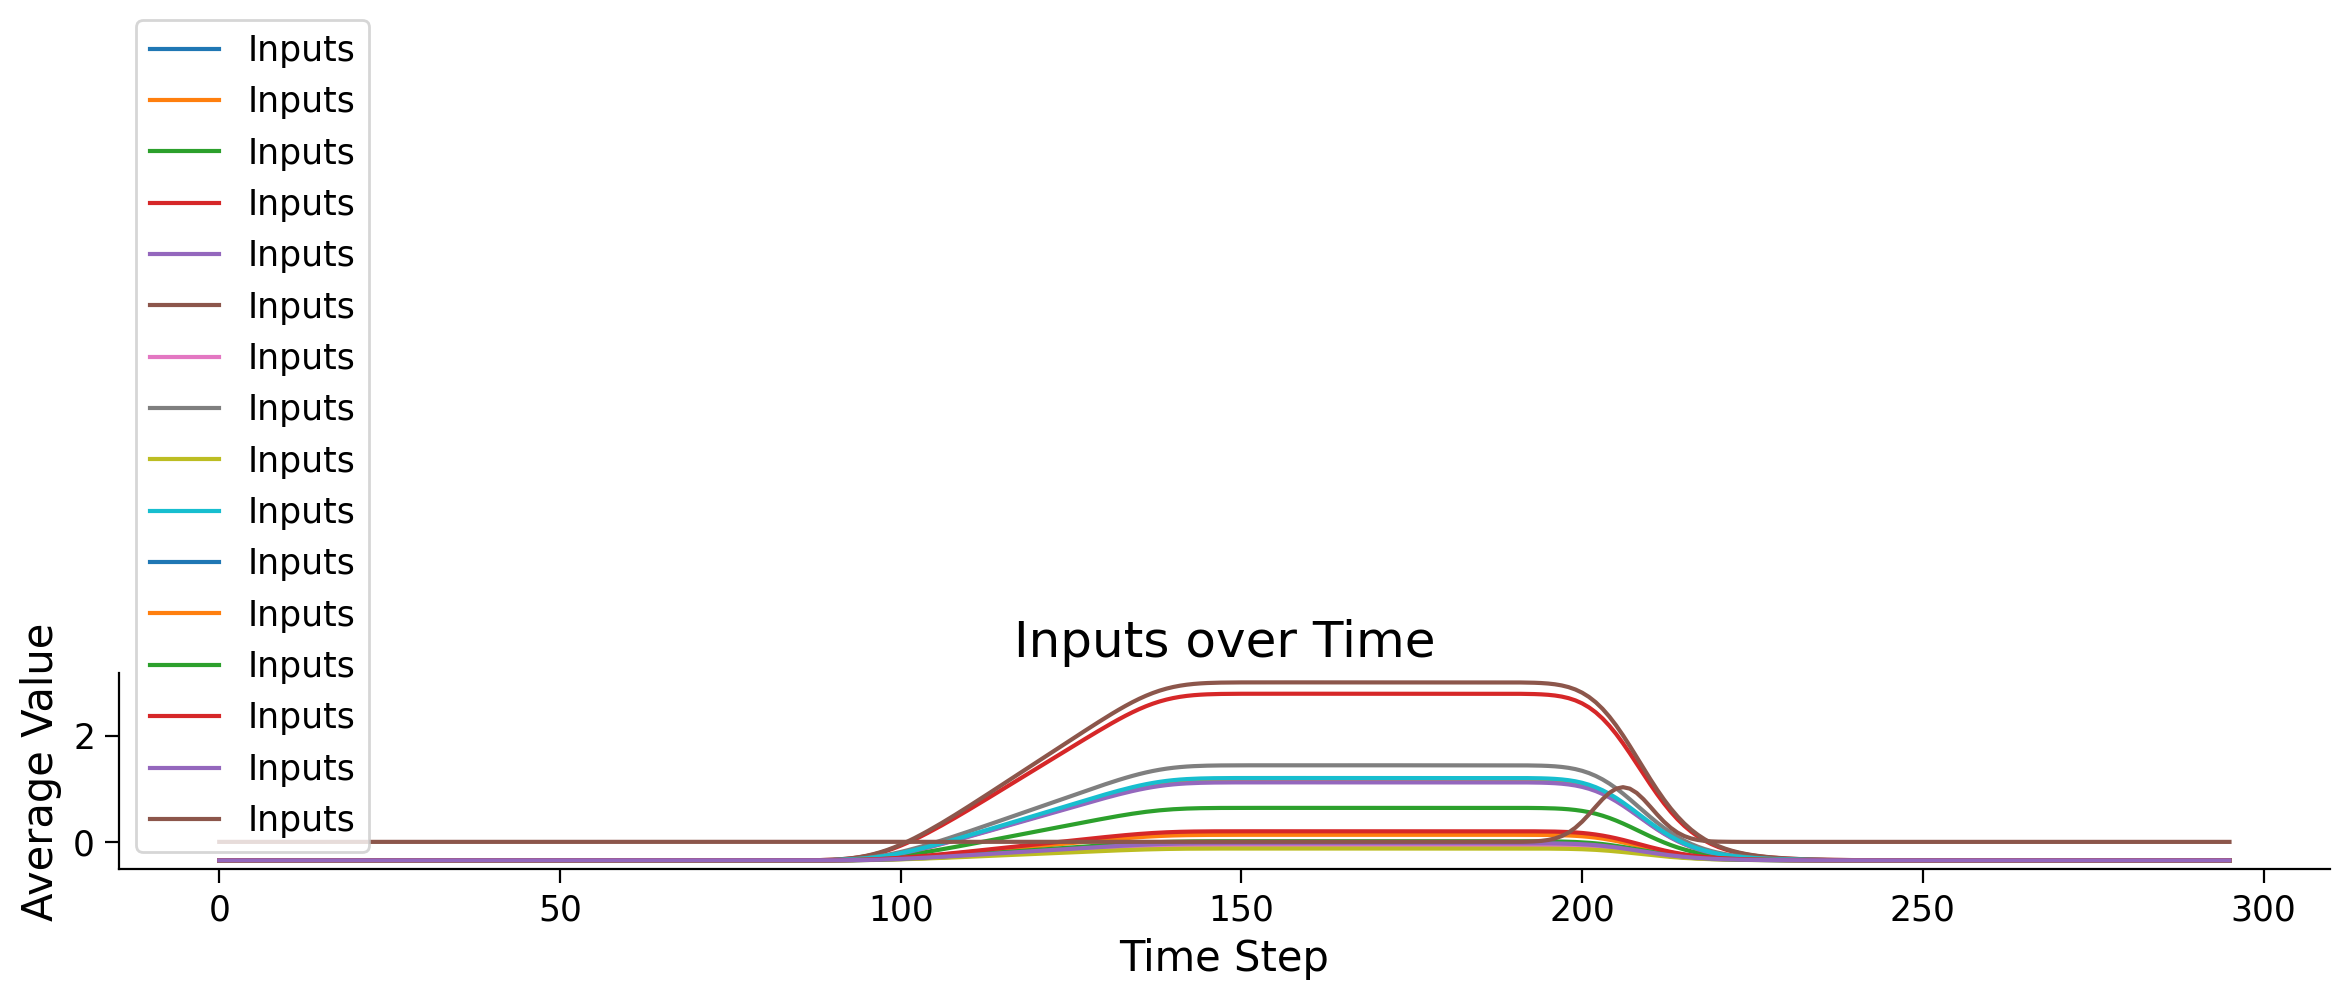

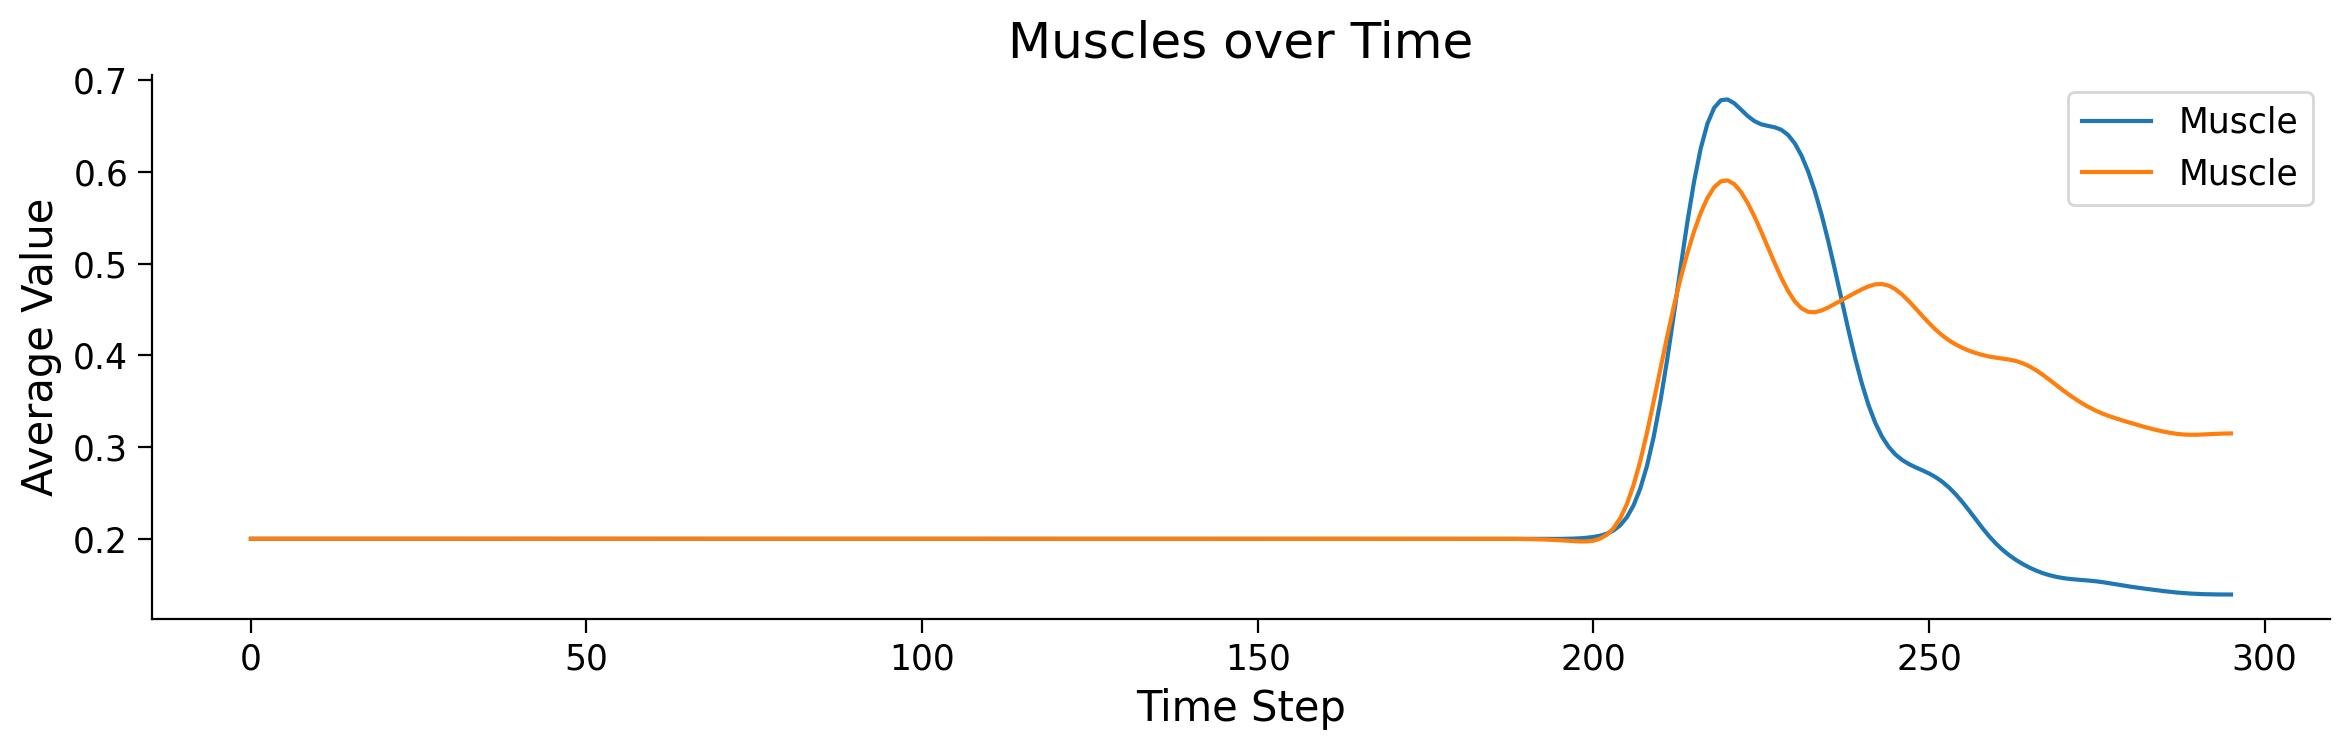

In [8]:
file_path = 'condsForSimJ2moMuscles.mat'  
normalised_inputs, output, num_conditions, num_delays = prepare_dataset(file_path)

# Averaging across conditions and delays
avg_inputs = normalised_inputs.mean(dim=[0, 1]).squeeze()
avg_output = output.mean(dim=[0, 1])

# Time steps
timesteps = np.arange(296)

plot_inputs_over_time(timesteps, avg_inputs)
plot_muscles_over_time(timesteps, avg_output)

In [9]:
# Flatten the first two dimensions (conditions and delays)
flattened_inputs = normalised_inputs.view(-1, *normalised_inputs.shape[2:])
flattened_targets = output.view(-1, *output.shape[2:])

class SimpleTimeseriesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        
        print("Shape of inputs - SimpleRNN", self.inputs.shape)
        print("Shape of targets - SimpleRNN", self.targets.shape)

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]
        target_seq = self.targets[idx]
        return input_seq, target_seq

# Create the SimpleRNN dataset
simple_dataset = SimpleTimeseriesDataset(flattened_inputs, flattened_targets)

# Split the dataset
simple_train_size = int(0.6 * len(simple_dataset))
simple_val_size = int(0.2 * len(simple_dataset))
simple_test_size = len(simple_dataset) - simple_train_size - simple_val_size

simple_train_dataset, simple_val_dataset, simple_test_dataset = random_split(simple_dataset, [simple_train_size, simple_val_size, simple_test_size])

batch_size = 31

# Create DataLoaders
simple_train_loader = DataLoader(simple_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, worker_init_fn=seed_worker)
simple_val_loader = DataLoader(simple_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, worker_init_fn=seed_worker)
simple_test_loader = DataLoader(simple_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, worker_init_fn=seed_worker)


Shape of inputs - SimpleRNN torch.Size([216, 296, 16])
Shape of targets - SimpleRNN torch.Size([216, 296, 2])


In [10]:
class ComplicatedTimeseriesDataset(Dataset):
    def __init__(self, inputs, targets, delay_idx):
        """
        inputs: Tensor of shape [27, 8, 296, input_features]
        targets: Tensor of shape [27, 8, 296, output_features]
        delay_idx: Fixed index of the delay to be used
        """
        self.inputs = inputs[:, delay_idx]
        self.targets = targets[:, delay_idx]
        self.num_conditions = inputs.shape[0]

        print("Shape of inputs - ComplicatedRNN", self.inputs.shape)
        print("Shape of targets - ComplicatedRNN", self.targets.shape)

    def __len__(self):
        return self.num_conditions

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]
        target_seq = self.targets[idx]
        return input_seq, target_seq

# Choose the delay index
fixed_delay_idx = 3

# Create the dataset with the fixed delay
complicated_dataset = ComplicatedTimeseriesDataset(normalised_inputs, output, fixed_delay_idx)

# Split the dataset
train_size = int(0.6 * len(complicated_dataset))
val_size = int(0.2 * len(complicated_dataset))
test_size = len(complicated_dataset) - train_size - val_size

complicated_train_dataset, complicated_val_dataset, complicated_test_dataset = random_split(complicated_dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 1
complicated_train_loader = DataLoader(complicated_train_dataset, batch_size=batch_size, shuffle=True)
complicated_val_loader = DataLoader(complicated_val_dataset, batch_size=batch_size, shuffle=False)
complicated_test_loader = DataLoader(complicated_test_dataset, batch_size=batch_size, shuffle=False)


Shape of inputs - ComplicatedRNN torch.Size([27, 296, 16])
Shape of targets - ComplicatedRNN torch.Size([27, 296, 2])


In [11]:
def validate_model(model, val_loader, criterion, device):  
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)

            for t in range(inputs.shape[1]):
                # Capture any additional outputs in 'rest' 
                output, h, *rest = model(inputs[:, t, :], h)
            
            loss = criterion(output, targets[:, -1, :])
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss

In [12]:
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)

            for t in range(inputs.shape[1]):
                # Capture any additional outputs in 'rest' 
                output, h, *rest = model(inputs[:, t, :], h)
            
            loss = criterion(output, targets[:, -1, :])
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    return avg_test_loss

In [13]:
# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0) # was torch.where(x > 0, x, torch.tanh(x))
def grad_rectified_tanh(x):
    return torch.where(x > 0, 1 - torch.tanh(x)**2, 0)
def grad_tanh(x):
    return 1 - torch.tanh(x)**2

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu
Random seed 2024 has been set.
Epoch 1, Training Loss: 0.0656910240650177
Epoch 1, Validation Loss: 0.00915599474683404
Epoch 2, Training Loss: 0.02584606111049652
Epoch 2, Validation Loss: 0.013398626819252968
Epoch 3, Training Loss: 0.01433856226503849
Epoch 3, Validation Loss: 0.004795688204467297
Epoch 4, Training Loss: 0.013667006604373455
Epoch 4, Validation Loss: 0.0014764847001060843
Epoch 5, Training Loss: 0.010279214940965176
Epoch 5, Validation Loss: 0.002014059806242585
Epoch 6, Training Loss: 0.010141879599541426
Epoch 6, Validation Loss: 0.0018417989485897124
Epoch 7, Training Loss: 0.009951029717922211
Epoch 7, Validation Loss: 0.0014566699101123959
Epoch 8, Training Loss: 0.009438155405223369
Epoch 8, Validation Loss: 0.0019566749688237906
Epoch 9, Training Loss: 0.01038264250382781
Epoch 9, Validation Loss: 0.0008

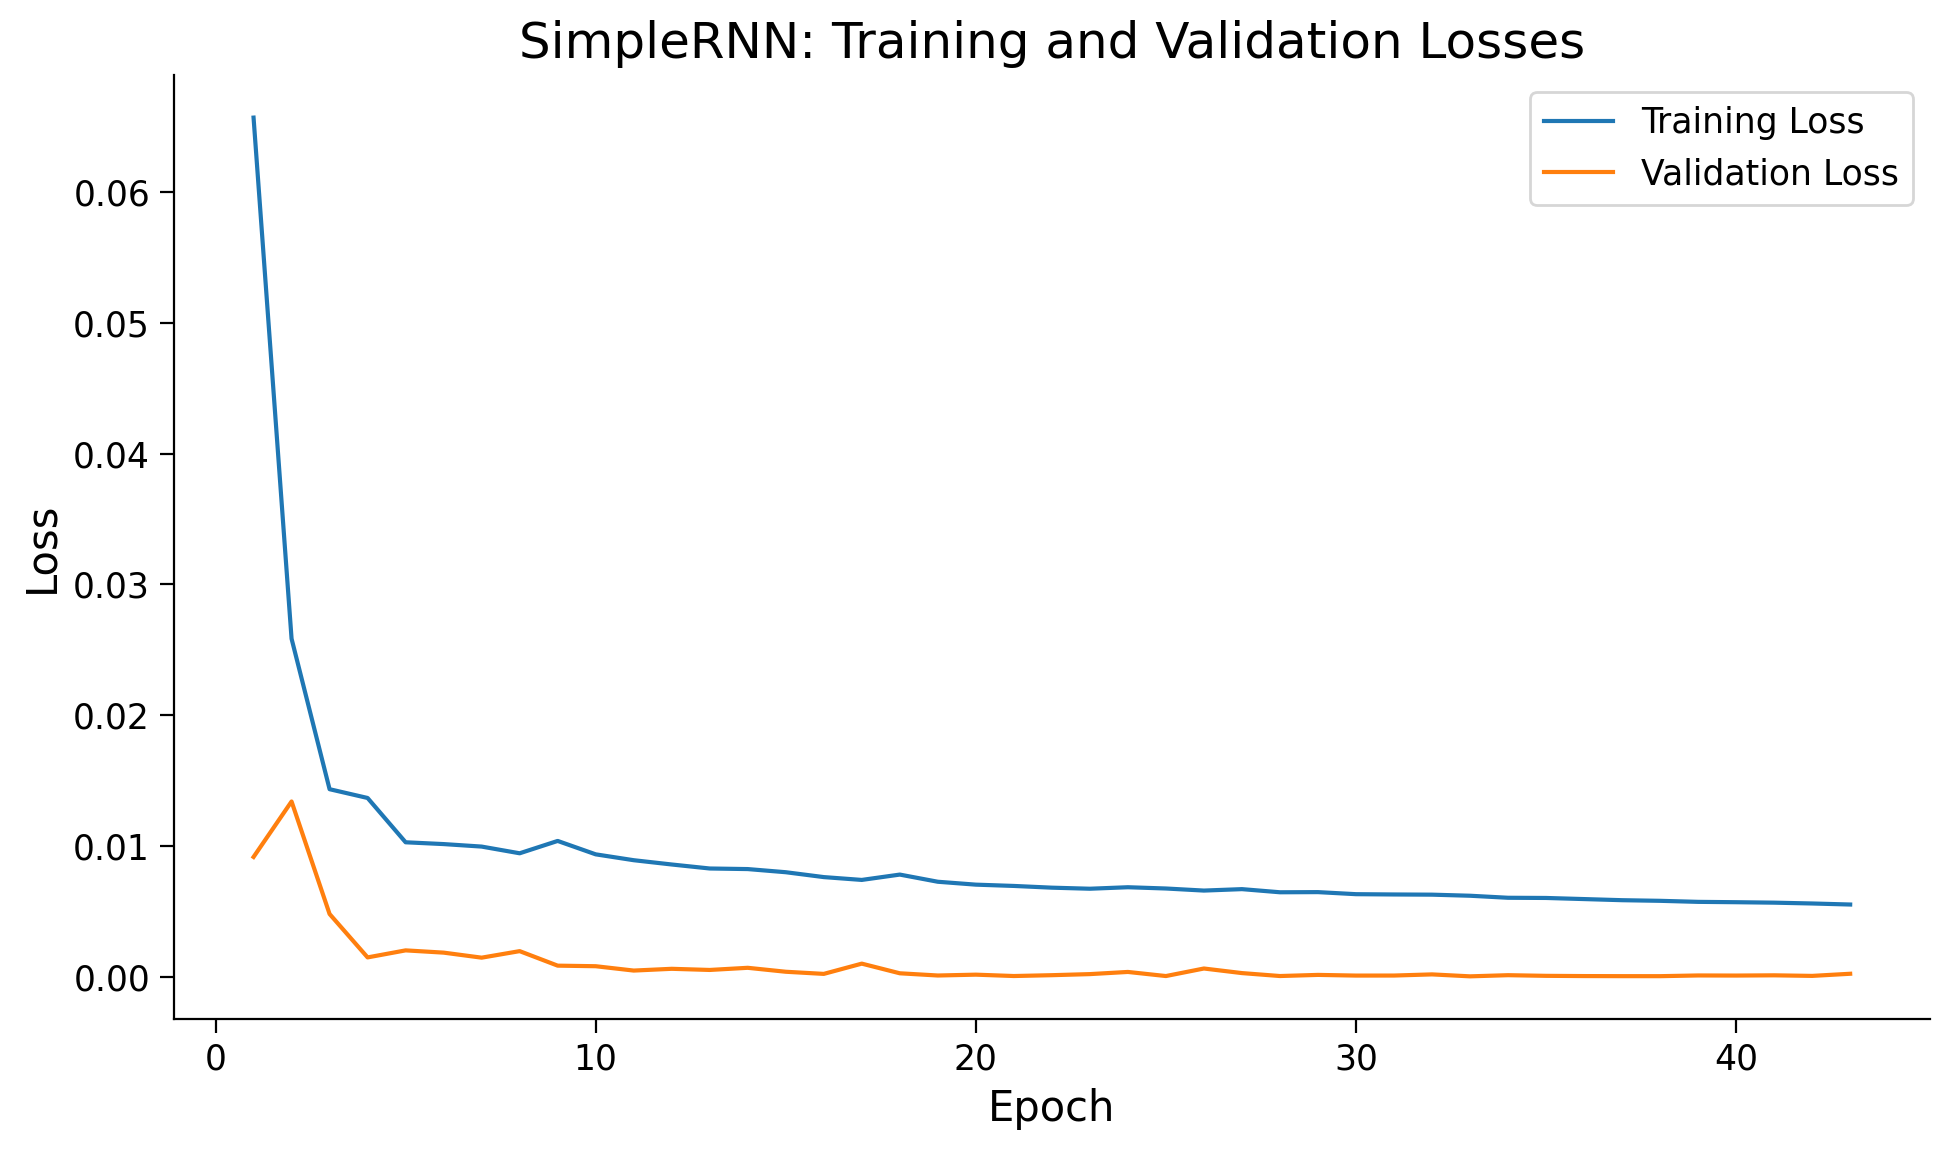

In [14]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant
        self.output_linear = nn.Linear(hidden_size, output_size)  

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh 
         
    def forward(self, x, hidden):
        hidden_prev = hidden.clone()
        timestep = self.tau / 10  # Timestep for Euler integration    
        # Update hidden state
        firing_rate = self.nonlinearity(hidden)        
        hidden_update = torch.matmul(self.J, firing_rate.transpose(0, 1)) 
        input_update = torch.matmul(self.B, x.transpose(0, 1))        
        new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)
        new_hidden = new_hidden.transpose(0, 1)    
        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden_prev + new_hidden)    
        # Output calculation
        output = self.output_linear(firing_rate)    
        # Regularization terms
        firing_rate_reg = hidden.pow(2).sum()
        dynamic_reg = torch.linalg.norm(torch.matmul(self.J, grad_rectified_tanh(hidden.transpose(0, 1))), ord='fro', dim=(-2, -1)).sum()
 
        return output, hidden, firing_rate_reg, dynamic_reg

    def init_hidden(self, batch_size):
        # Initialize hidden state with batch dimension
        return torch.zeros(batch_size, self.hidden_size)

def compute_l2_regularization(parameters, alpha):
    l2_reg = sum(p.pow(2.0).sum() for p in parameters)
    return alpha * l2_reg

# Hyperparameters
input_size = 16 # Features + Go Cue
hidden_size = 150
output_size = 2  # Number of muscles
g = 1.5  # g value
h_val = 1.0  # h value

# Hyperparameters for regularization
alpha = 1e-5  
beta = 0.003
gamma = 1e-6

# Training Loop
num_epochs = 100
epoch_losses = [] 
val_losses = []

patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# get available device
device = set_device()

# Model instantiation
set_seed(seed=2024) 
model = SimpleRNN(input_size, hidden_size, output_size, g, h_val)
model.to(device)

# Loss Function and Optimizer
criterion = nn.MSELoss()  # MSE Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0) ### WD=0. Note: Paper uses Hessian-Free optimizer
scaler = GradScaler()

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set the model to training mode

    # Initialize hidden states 
    hidden_states_for_plot = []

    for inputs, targets in simple_train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        h = model.init_hidden(batch_size).to(device)
        optimizer.zero_grad() 

        total_firing_rate_reg = 0
        total_dynamic_reg = 0

        with autocast():  # Enable automatic mixed precision
            for t in range(inputs.shape[1]):
                output, h, firing_rate_reg, dynamic_reg = model(inputs[:, t, :], h)
                hidden_states_for_plot.append(h.detach().cpu().numpy())
                total_firing_rate_reg += firing_rate_reg
                total_dynamic_reg += dynamic_reg

            # Compute loss and regularization terms
            loss = criterion(output, targets[:, -1, :])
            l2_reg = compute_l2_regularization(model.parameters(), alpha)
            rfr_reg = beta * total_firing_rate_reg / inputs.shape[1] / hidden_size / num_conditions #CNT where C is 27 conditions, N is 300 neurons and T is 296 timesteps
            rj_reg = gamma * total_dynamic_reg / inputs.shape[1] / num_conditions #CT
            total_loss = loss + l2_reg + rfr_reg + rj_reg

        scaler.scale(total_loss).backward()  # Scale loss and perform backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        scaler.step(optimizer)  # Update optimizer
        scaler.update()  # Update scaler

        running_loss += total_loss.item()

    avg_loss = running_loss / len(simple_train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_loss}')

    # Validation phase after completing the training for one epoch
    val_loss = validate_model(model, simple_val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered at epoch", epoch + 1)
        early_stop = True
        break

    # Clear CUDA cache if needed
    if device == 'cuda':
        torch.cuda.empty_cache()

# Check if training was stopped by early stopping
if early_stop:
    print('Training stopped due to early stopping at epoch', epoch + 1)
else:
    print('Finished Training')
# Testing phase
test_loss = test_model(model, simple_test_loader, criterion, device)
print(f'Test Loss: {test_loss}')

# Clear cache after training
if device == 'cuda':
    torch.cuda.empty_cache()
    
# Determine the number of epochs for which you have loss data
actual_num_epochs = len(epoch_losses)  # This will be less than num_epochs if early stopping was triggered

# Call the plotting function
plot_training_validation_losses(epoch_losses, val_losses, actual_num_epochs, "SimpleRNN: Training and Validation Losses")

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu
Epoch 1, Training Loss: 0.031955975806340575
Epoch 1, Validation Loss: 0.011464350676396862
Epoch 2, Training Loss: 0.00576517640183738
Epoch 2, Validation Loss: 0.0032829128205776213
Epoch 3, Training Loss: 0.0026113963713214616
Epoch 3, Validation Loss: 0.00479471255093813
Epoch 4, Training Loss: 0.002299478751240258
Epoch 4, Validation Loss: 0.0057133041205815974
Epoch 5, Training Loss: 0.0028472238159338303
Epoch 5, Validation Loss: 0.008566025109030307
Epoch 6, Training Loss: 0.004182195178145776
Epoch 6, Validation Loss: 0.007528607780113816
Epoch 7, Training Loss: 0.002034495044426876
Epoch 7, Validation Loss: 0.002205248945392668
Epoch 8, Training Loss: 0.002650745511346031
Epoch 8, Validation Loss: 0.0017992844863329084
Epoch 9, Training Loss: 0.0031825138939893804
Epoch 9, Validation Loss: 0.006439653201960027
Epoch 10, 

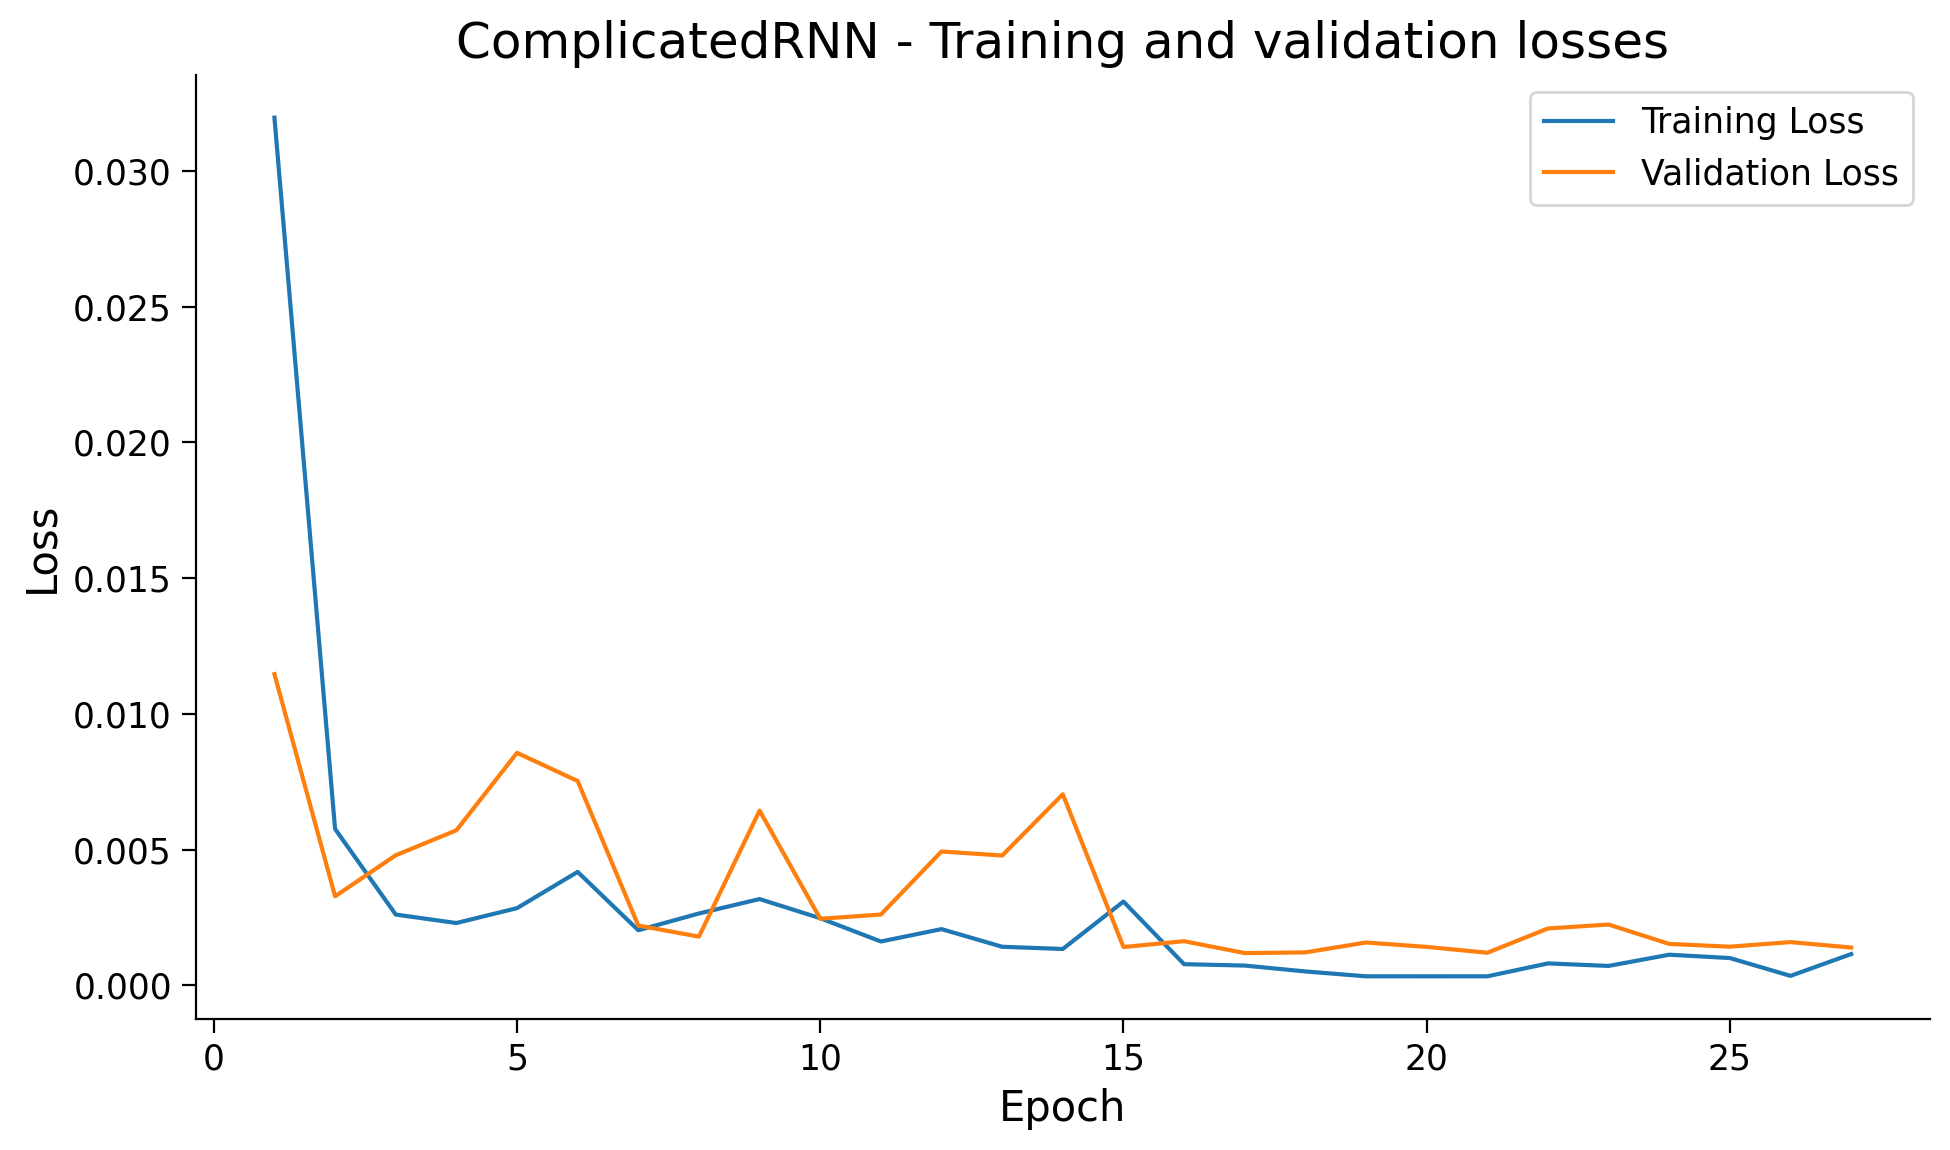

In [15]:
# ComplicatedRNN class
class ComplicatedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(ComplicatedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau
        self.output_linear = nn.Linear(hidden_size, output_size)

        # Weight initialization (unchanged)
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity (unchanged)
        self.nonlinearity = rectified_tanh 
        
    def forward(self, x, hidden):
        # Forward pass logic (same as SimpleRNN but without regularization terms)
        hidden_prev = hidden.clone()
        timestep = self.tau / 10
        #Update hidden state
        firing_rate = self.nonlinearity(hidden)        
        hidden_update = torch.matmul(self.J, firing_rate.transpose(0, 1))
        input_update = torch.matmul(self.B, x.transpose(0, 1))     
        new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)
        new_hidden = new_hidden.transpose(0, 1)
        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden_prev + new_hidden)
        output = self.output_linear(firing_rate)
        
        return output, hidden
        
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

# Training loop
# Hyperparameters
input_size = 16
hidden_size = 300
output_size = 2  # Number of muscles
g = 4  # g value
h_val = 1.0  # h value

# Training Loop
num_epochs = 100
epoch_losses = [] 
val_losses = []

patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# get available device
device = set_device()

# Model instantiation
complicated_model = ComplicatedRNN(input_size, hidden_size, output_size, g, h_val)
complicated_model.to(device)

# Loss function and optimizer (no weight decay)
criterion = nn.MSELoss()
optimizer = optim.Adam(complicated_model.parameters(), lr=0.001, weight_decay=0)
scaler = GradScaler()

# Training loop 
for epoch in range(num_epochs):
    running_loss = 0.0
    hidden_states_for_plot_cm = []

    complicated_model.train()  # Set the model to training mode
    for inputs, targets in complicated_train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        h = complicated_model.init_hidden(batch_size).to(device)
        optimizer.zero_grad()

        with autocast():  # Apply automatic mixed precision
            for t in range(inputs.shape[1]):
                output, h = complicated_model(inputs[:, t, :], h)
                hidden_states_for_plot_cm.append(h.detach().cpu().numpy())

            loss = criterion(output, targets[:, -1, :])

        scaler.scale(loss).backward()  # Scale loss for backward pass
        scaler.step(optimizer)  # Update optimizer with scaled gradients
        scaler.update()  # Update the scaler

        running_loss += loss.item()

    avg_loss = running_loss / len(complicated_train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_loss}')

    # Validation phase after completing the training for one epoch
    val_loss = validate_model(complicated_model, complicated_val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered at epoch", epoch + 1)
        early_stop = True
        break

    # Clear CUDA cache if needed
    if device == 'cuda':
        torch.cuda.empty_cache()

# Check if training was stopped by early stopping
if early_stop:
    print('Training stopped due to early stopping at epoch', epoch + 1)
else:
    print('Finished Training')
# Testing phase
test_loss = test_model(complicated_model, complicated_test_loader, criterion, device)
print(f'Test Loss: {test_loss}')

# Clear cache after training
if device == 'cuda':
    torch.cuda.empty_cache()
    
# Determine the number of epochs for which you have loss data
actual_num_epochs = len(epoch_losses)  # This will be less than num_epochs if early stopping was triggered

# Call the plotting function
plot_training_validation_losses(epoch_losses, val_losses, actual_num_epochs, "ComplicatedRNN - Training and validation losses")


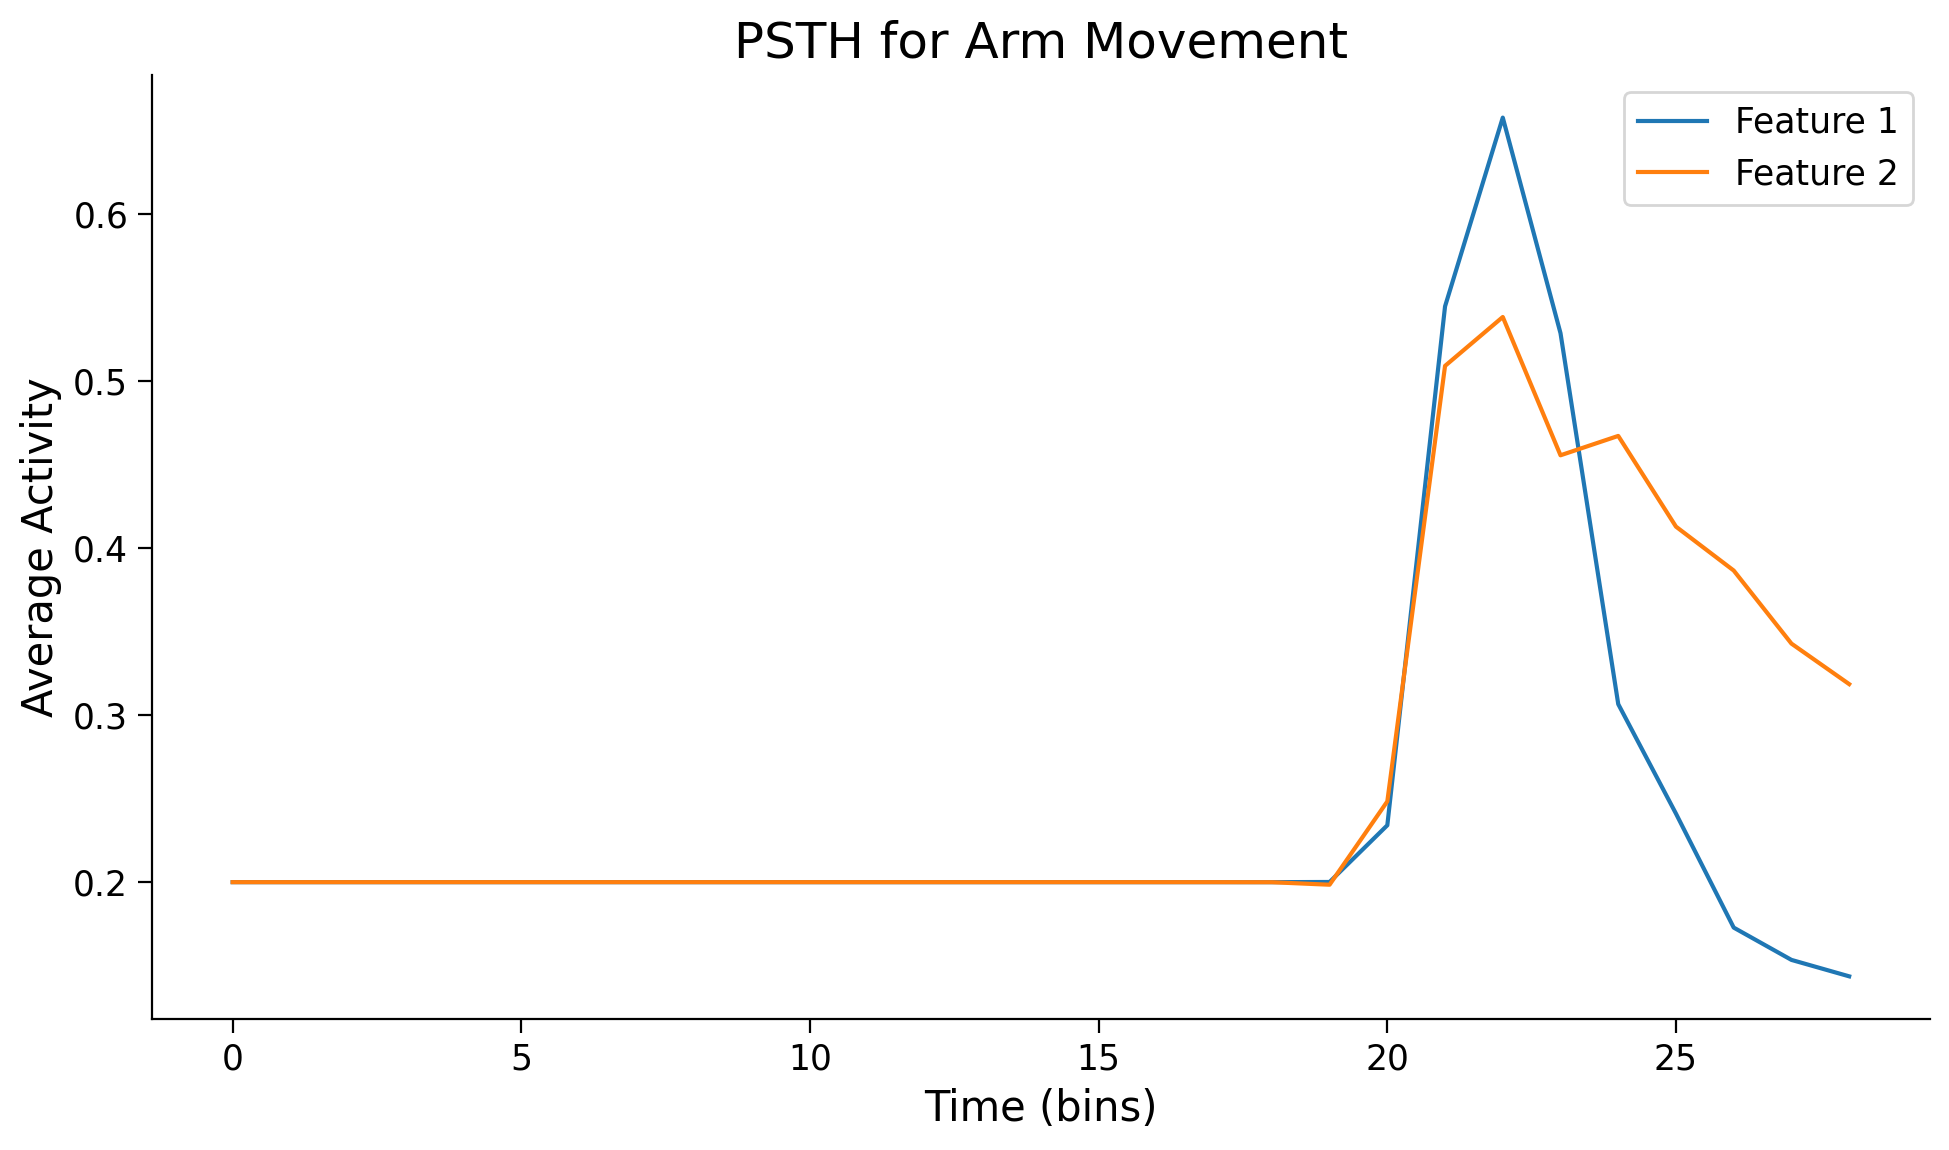

In [16]:
file_path = 'condsForSimJ2moMuscles.mat'  
normalised_inputs, output, num_conditions, num_delays = prepare_dataset(file_path)

# Plot PSTH for arm movement
plot_psth(output, "PSTH for Arm Movement")

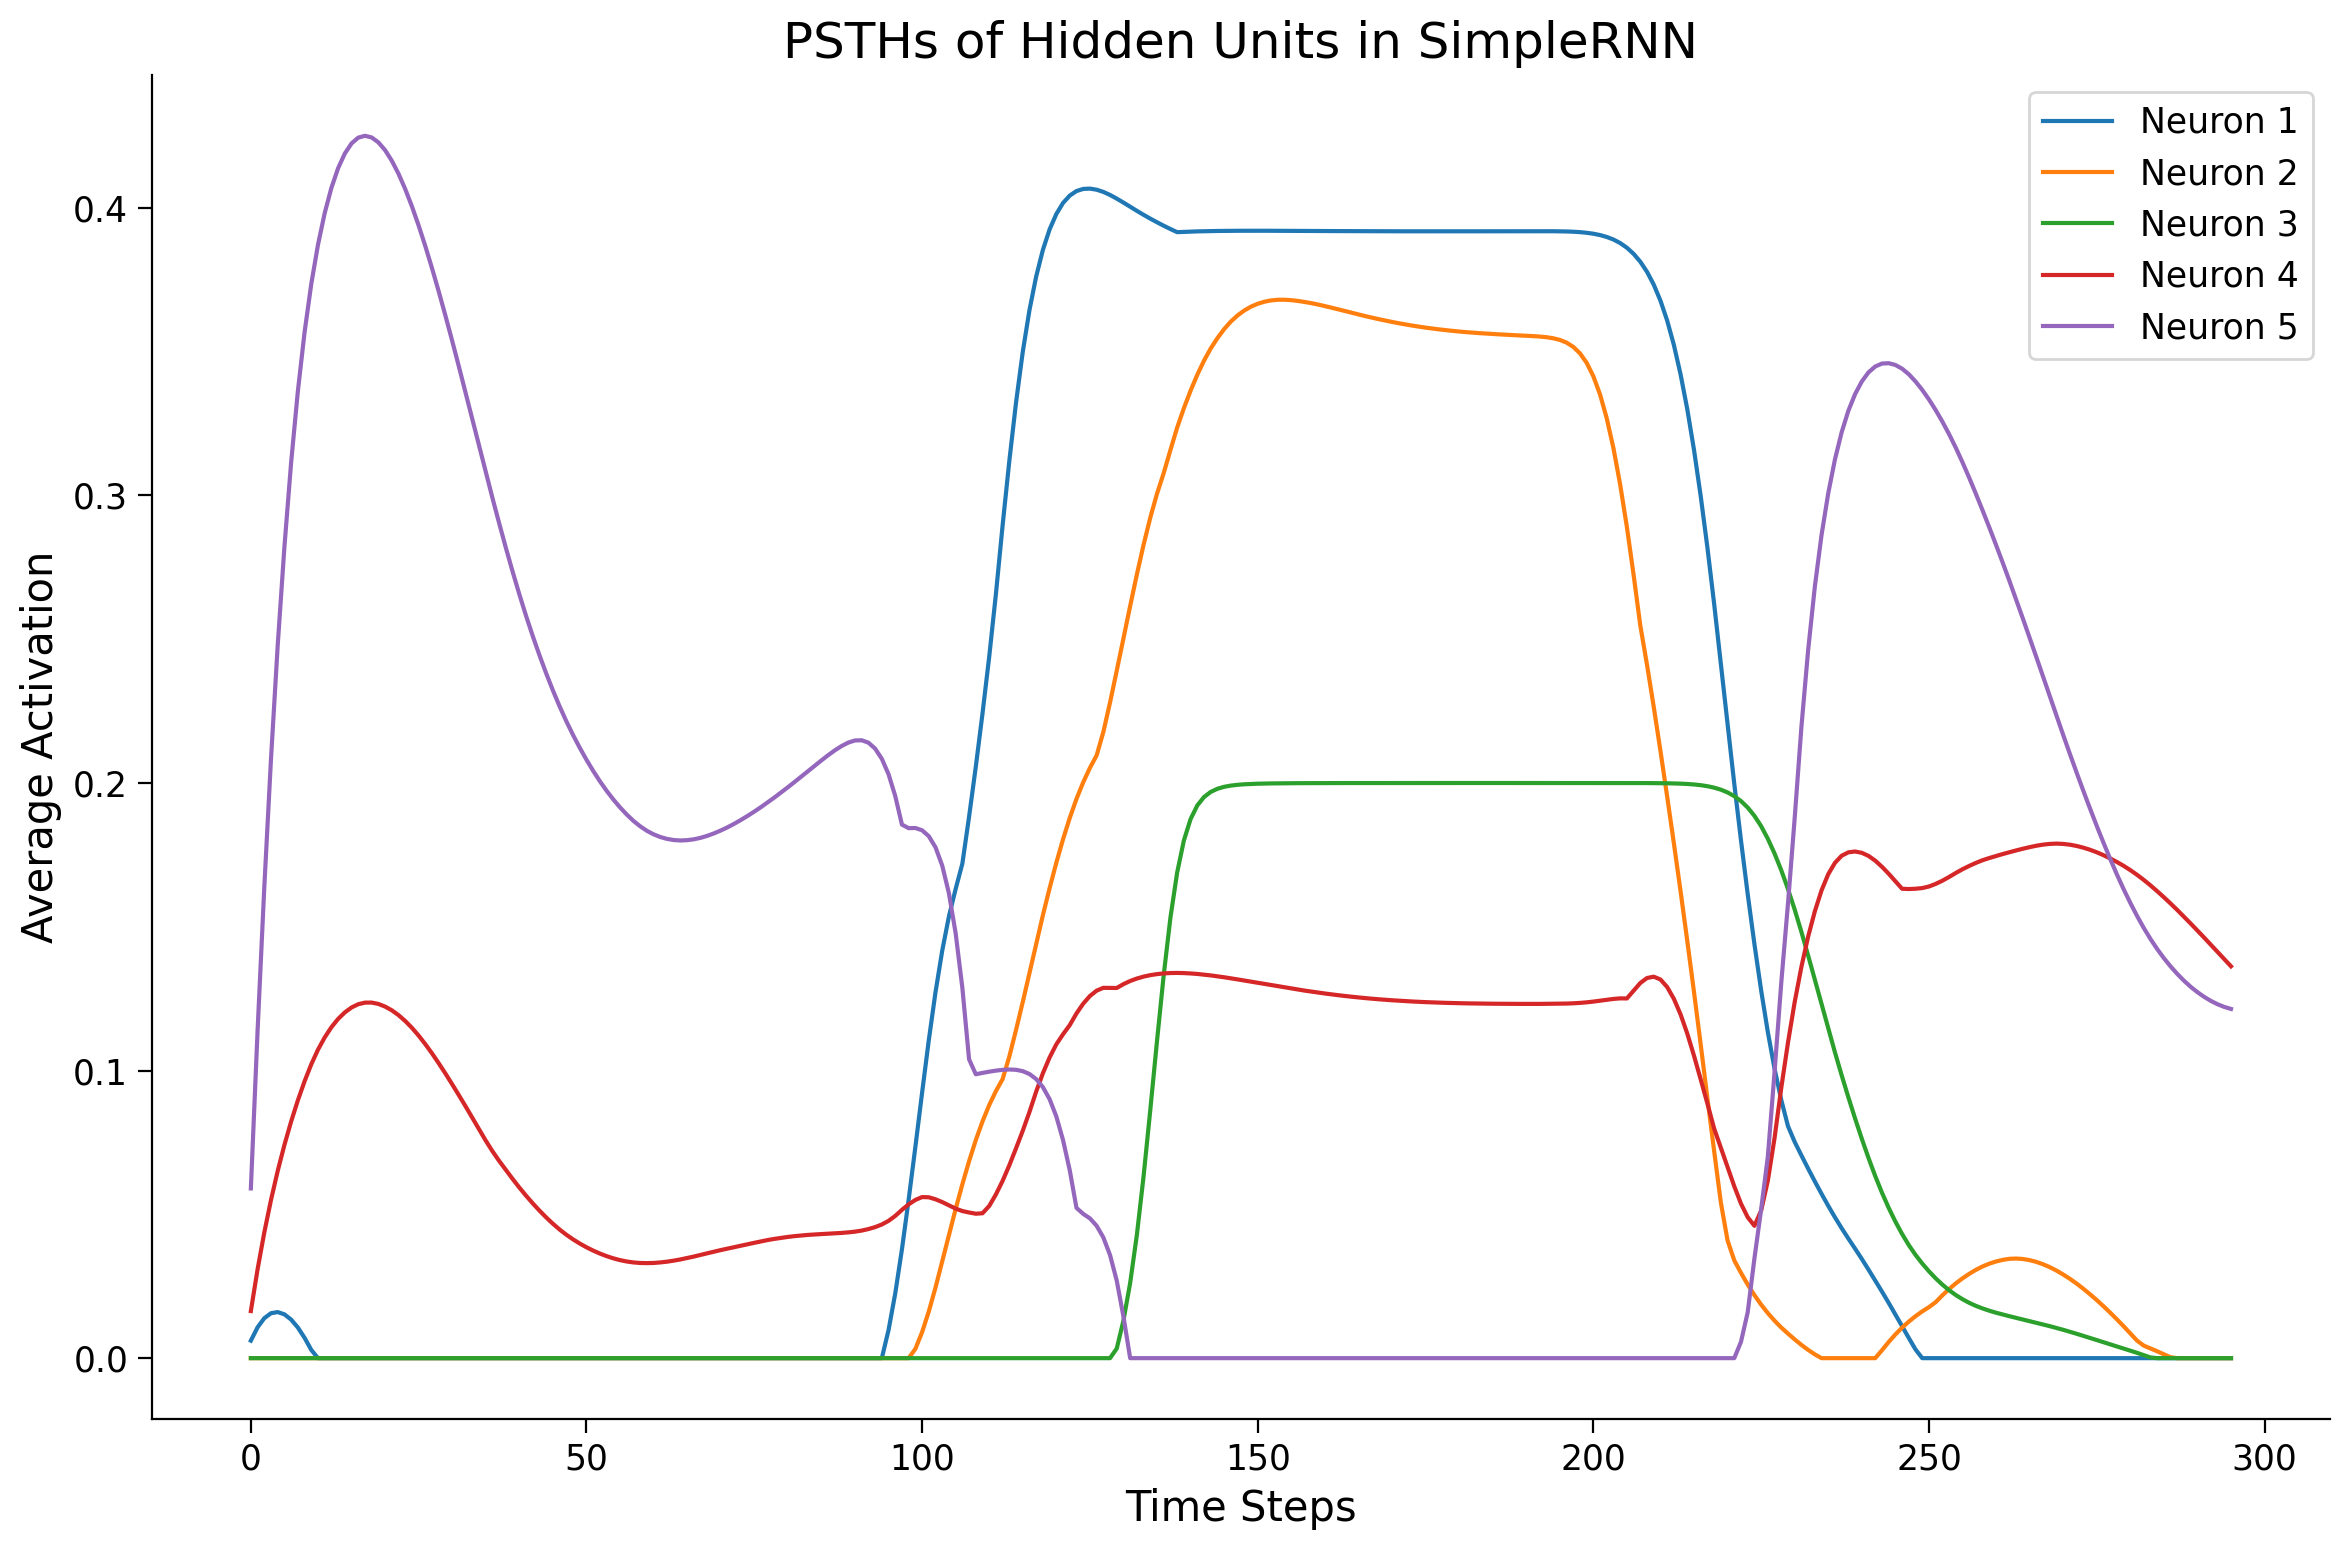

In [17]:
# Plot hidden units in SimpleRNN
plot_hidden_unit_activations(hidden_states=hidden_states_for_plot, timesteps=296, neurons_to_plot=5, title='PSTHs of Hidden Units in SimpleRNN')

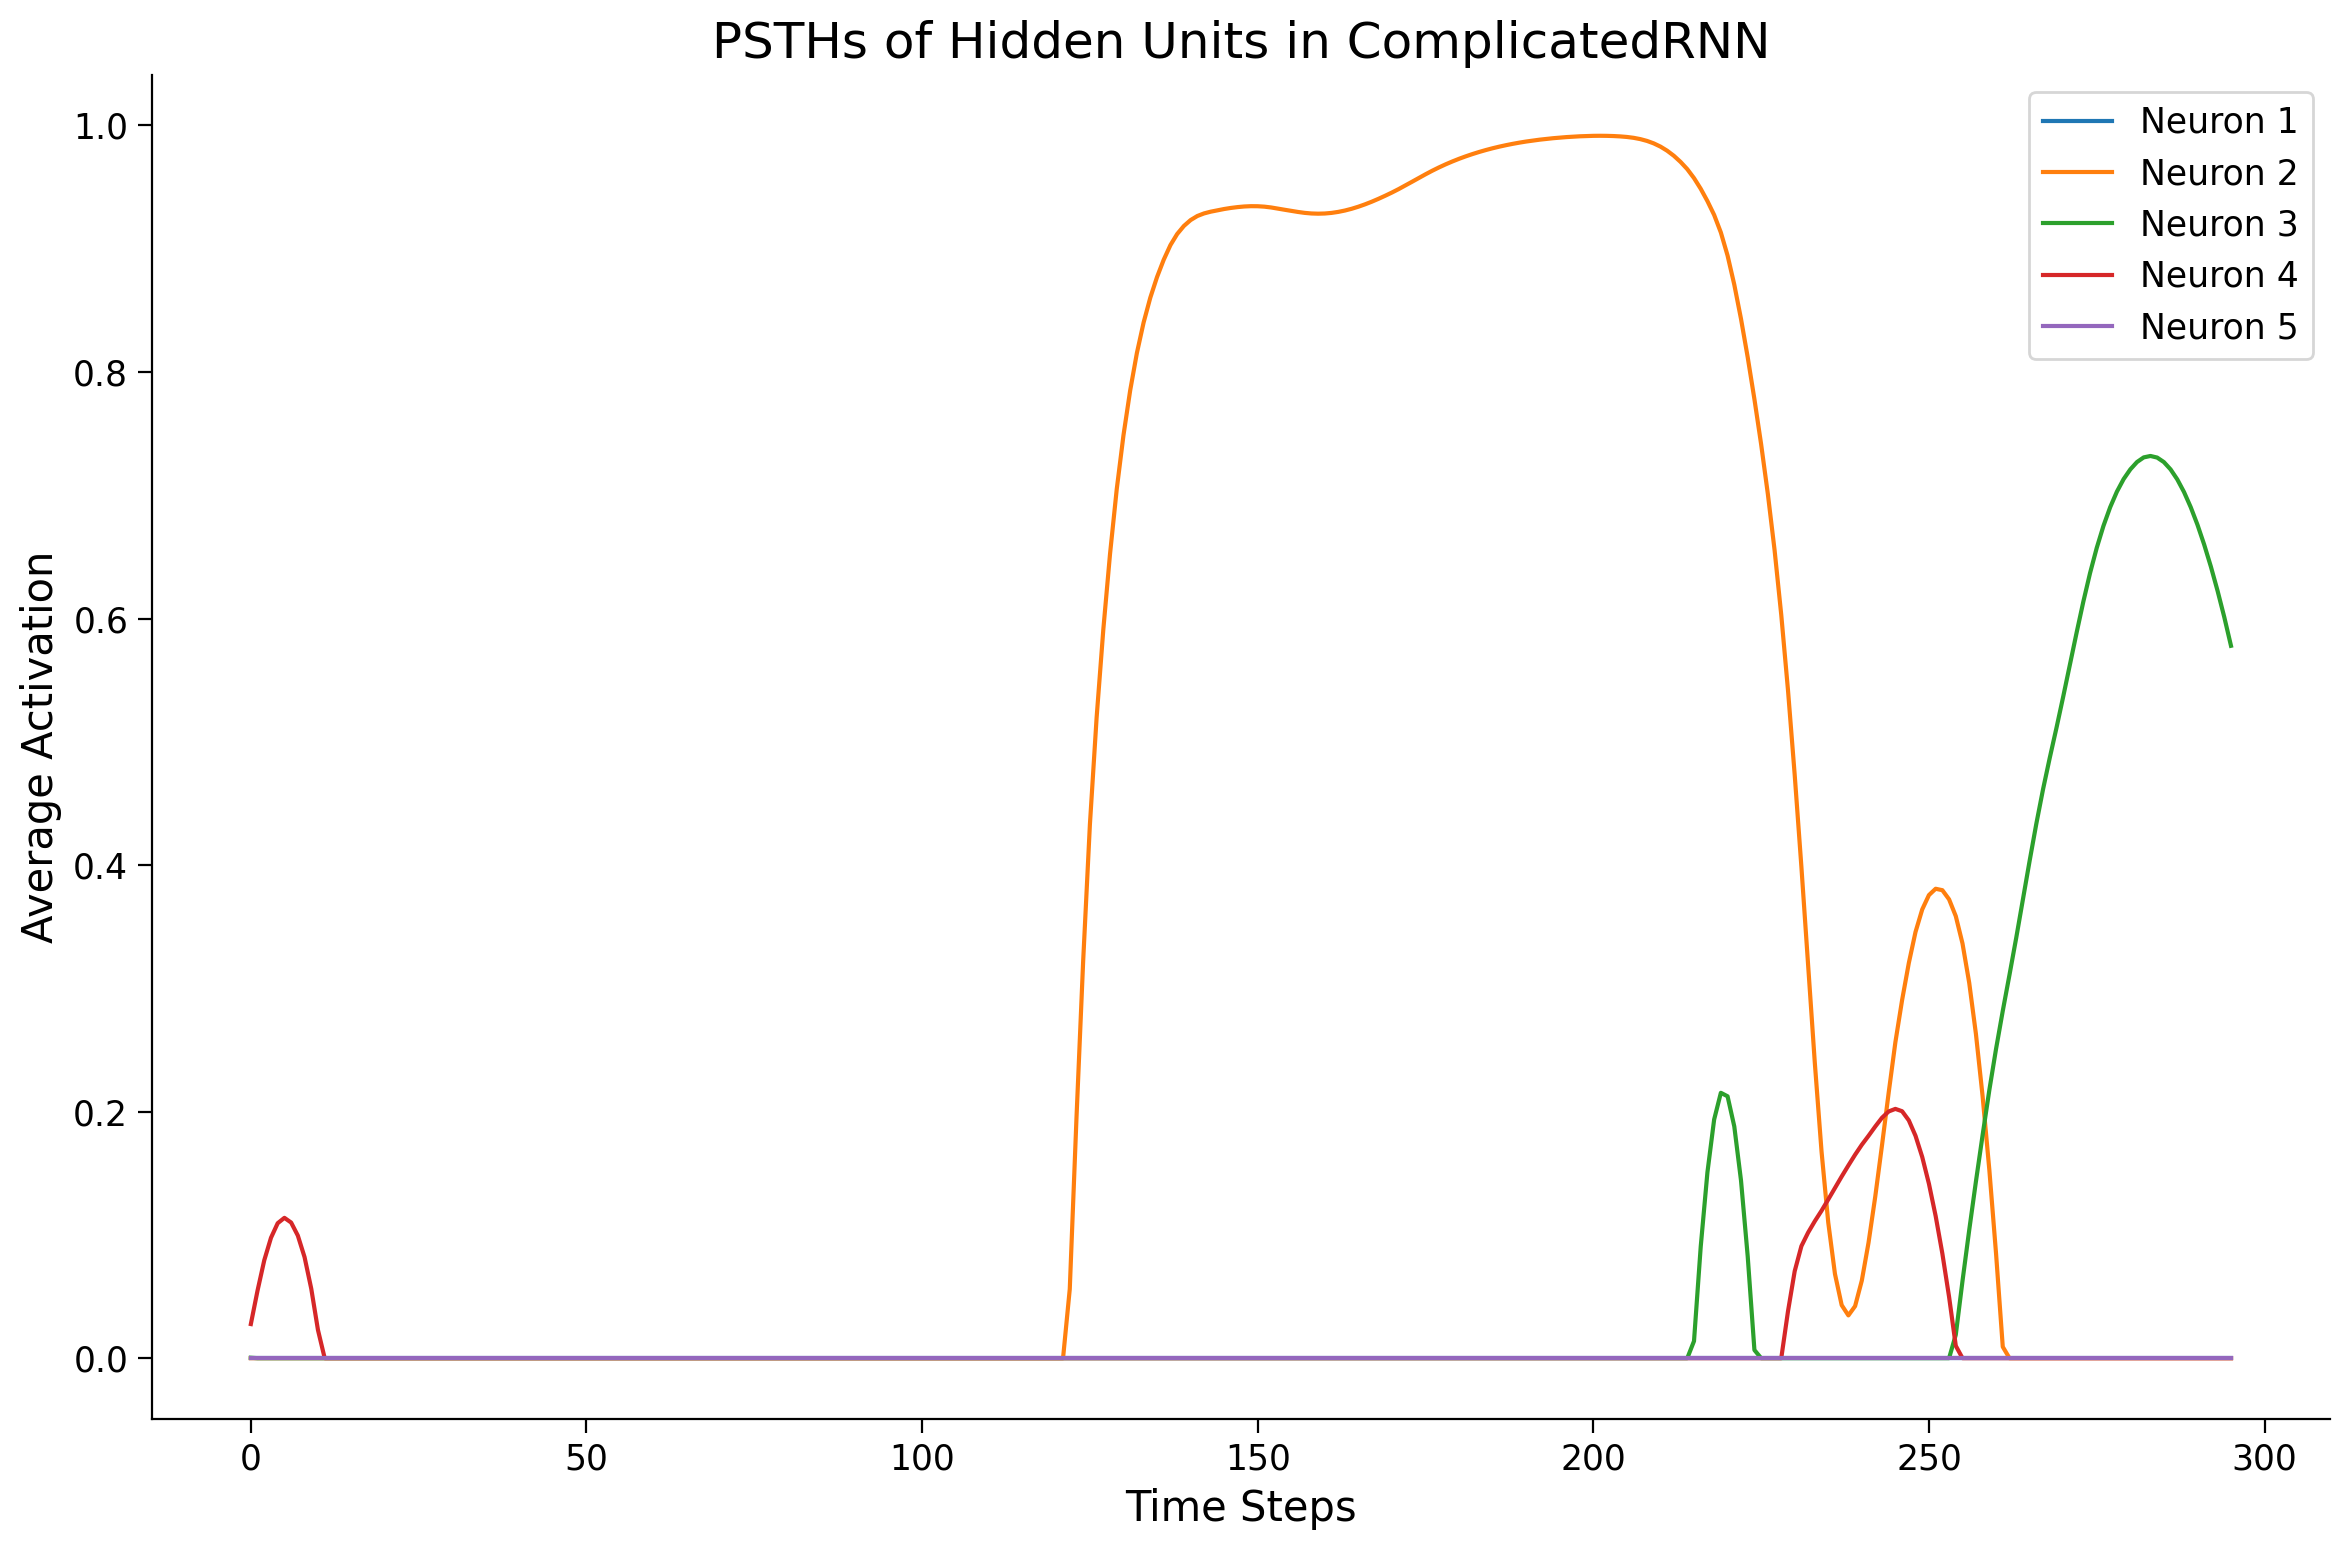

In [18]:
# Plot hidden units in ComplicatedRNN
plot_hidden_unit_activations(hidden_states=hidden_states_for_plot_cm, timesteps=296, neurons_to_plot=5, title='PSTHs of Hidden Units in ComplicatedRNN')

In [19]:
def perturb_inputs(model, inputs, perturbation_strength):
    device = inputs.device
    # Perturb the inputs by adding random noise scaled by the perturbation strength and input strength
    input_strength = torch.norm(inputs, p=2, dim=-1, keepdim=True)  # Calculate the L2 norm of inputs
    noise = torch.rand(inputs.shape[0], 1, inputs.shape[2], device=device) * perturbation_strength * input_strength    
    perturbed_inputs = inputs + noise
    return perturbed_inputs

def compute_loss(model, inputs, targets, criterion, device):
    batch_size = inputs.size(0)
    h = model.init_hidden(batch_size).to(device)  # Initialize hidden state
    losses = []
    for t in range(inputs.shape[1]):  # Iterate over time steps
        model_output = model(inputs[:, t, :], h)
        output, h, *rest = model_output[:2]
        loss = criterion(output, targets[:, t])  # Assume targets is a sequence of same length as inputs
        losses.append(loss)
    mean_loss = torch.mean(torch.stack(losses)).item()
    return mean_loss

def test_perturbed_inputs(model, perturbation_strengths, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    perturbation_results = []

    for strength in perturbation_strengths:
        all_errors = []  # Store all errors for each perturbation strength to compute mean and s.d.
        print(f"Testing perturbation strength {strength}")
        for iteration in range(100):  # Repeat the procedure 20 times
            batch_errors = []  # Store errors for each batch
            print(f" Iteration {iteration+1}/50")
            
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                # Compute error for original inputs
                original_loss = compute_loss(model, inputs, targets, criterion, device)
                # Compute error for perturbed inputs
                perturbed_inputs = perturb_inputs(model, inputs, strength)
                perturbed_loss = compute_loss(model, perturbed_inputs, targets, criterion, device)
                
                # Store the normalized error difference
                error_diff = abs(perturbed_loss - original_loss) / original_loss * 100  # Normalize as percentage
                error_diff = min(error_diff, 100)  # Truncate at 100%
                batch_errors.append(error_diff)
            
            all_errors.extend(batch_errors)
        
        mean_error = np.mean(all_errors)
        std_error = np.std(all_errors)
        perturbation_results.append((mean_error, std_error))
        print(f"Completed testing for perturbation strength {strength}.")
    
    return perturbation_results

import time

# Start time
start_time = time.time()

perturbation_strengths = [0.01, 0.1, 1]
results_complex = test_perturbed_inputs(complicated_model, perturbation_strengths, complicated_train_loader, criterion, device)
results_simple = test_perturbed_inputs(model, perturbation_strengths, simple_train_loader, criterion, device)

end_time = time.time()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Testing perturbation strength 0.01
 Iteration 1/50
 Iteration 2/50
 Iteration 3/50
 Iteration 4/50
 Iteration 5/50
 Iteration 6/50
 Iteration 7/50
 Iteration 8/50
 Iteration 9/50
 Iteration 10/50
 Iteration 11/50
 Iteration 12/50
 Iteration 13/50
 Iteration 14/50
 Iteration 15/50
 Iteration 16/50
 Iteration 17/50
 Iteration 18/50
 Iteration 19/50
 Iteration 20/50
 Iteration 21/50
 Iteration 22/50
 Iteration 23/50
 Iteration 24/50
 Iteration 25/50
 Iteration 26/50
 Iteration 27/50
 Iteration 28/50
 Iteration 29/50
 Iteration 30/50
 Iteration 31/50
 Iteration 32/50
 Iteration 33/50
 Iteration 34/50
 Iteration 35/50
 Iteration 36/50
 Iteration 37/50
 Iteration 38/50
 Iteration 39/50
 Iteration 40/50
 Iteration 41/50
 Iteration 42/50
 Iteration 43/50
 Iteration 44/50
 Iteration 45/50
 Iteration 46/50
 Iteration 47/50
 Iteration 48/50
 Iteration 49/50
 Iteration 50/50
 Iteration 51/50
 Iteration 52/50
 Iteration 53/50
 Iteration 54/50
 Iteration 55/50
 Iteration 56/50
 Iteration 57/50
 Iter

SimpleRNN: mean errors (0.5011416194166181, 6.684608408992907, 52.66522483443701)
ComplicatedRNN: mean errors (0.9357181643251389, 8.856414108052213, 33.40614851828241)
SimpleRNN: normalised mean errors [0.951560770873096, 12.692641928344983, 100.0]
ComplicatedRNN: normalised mean errors [2.801035754879202, 26.511329503325726, 100.0]


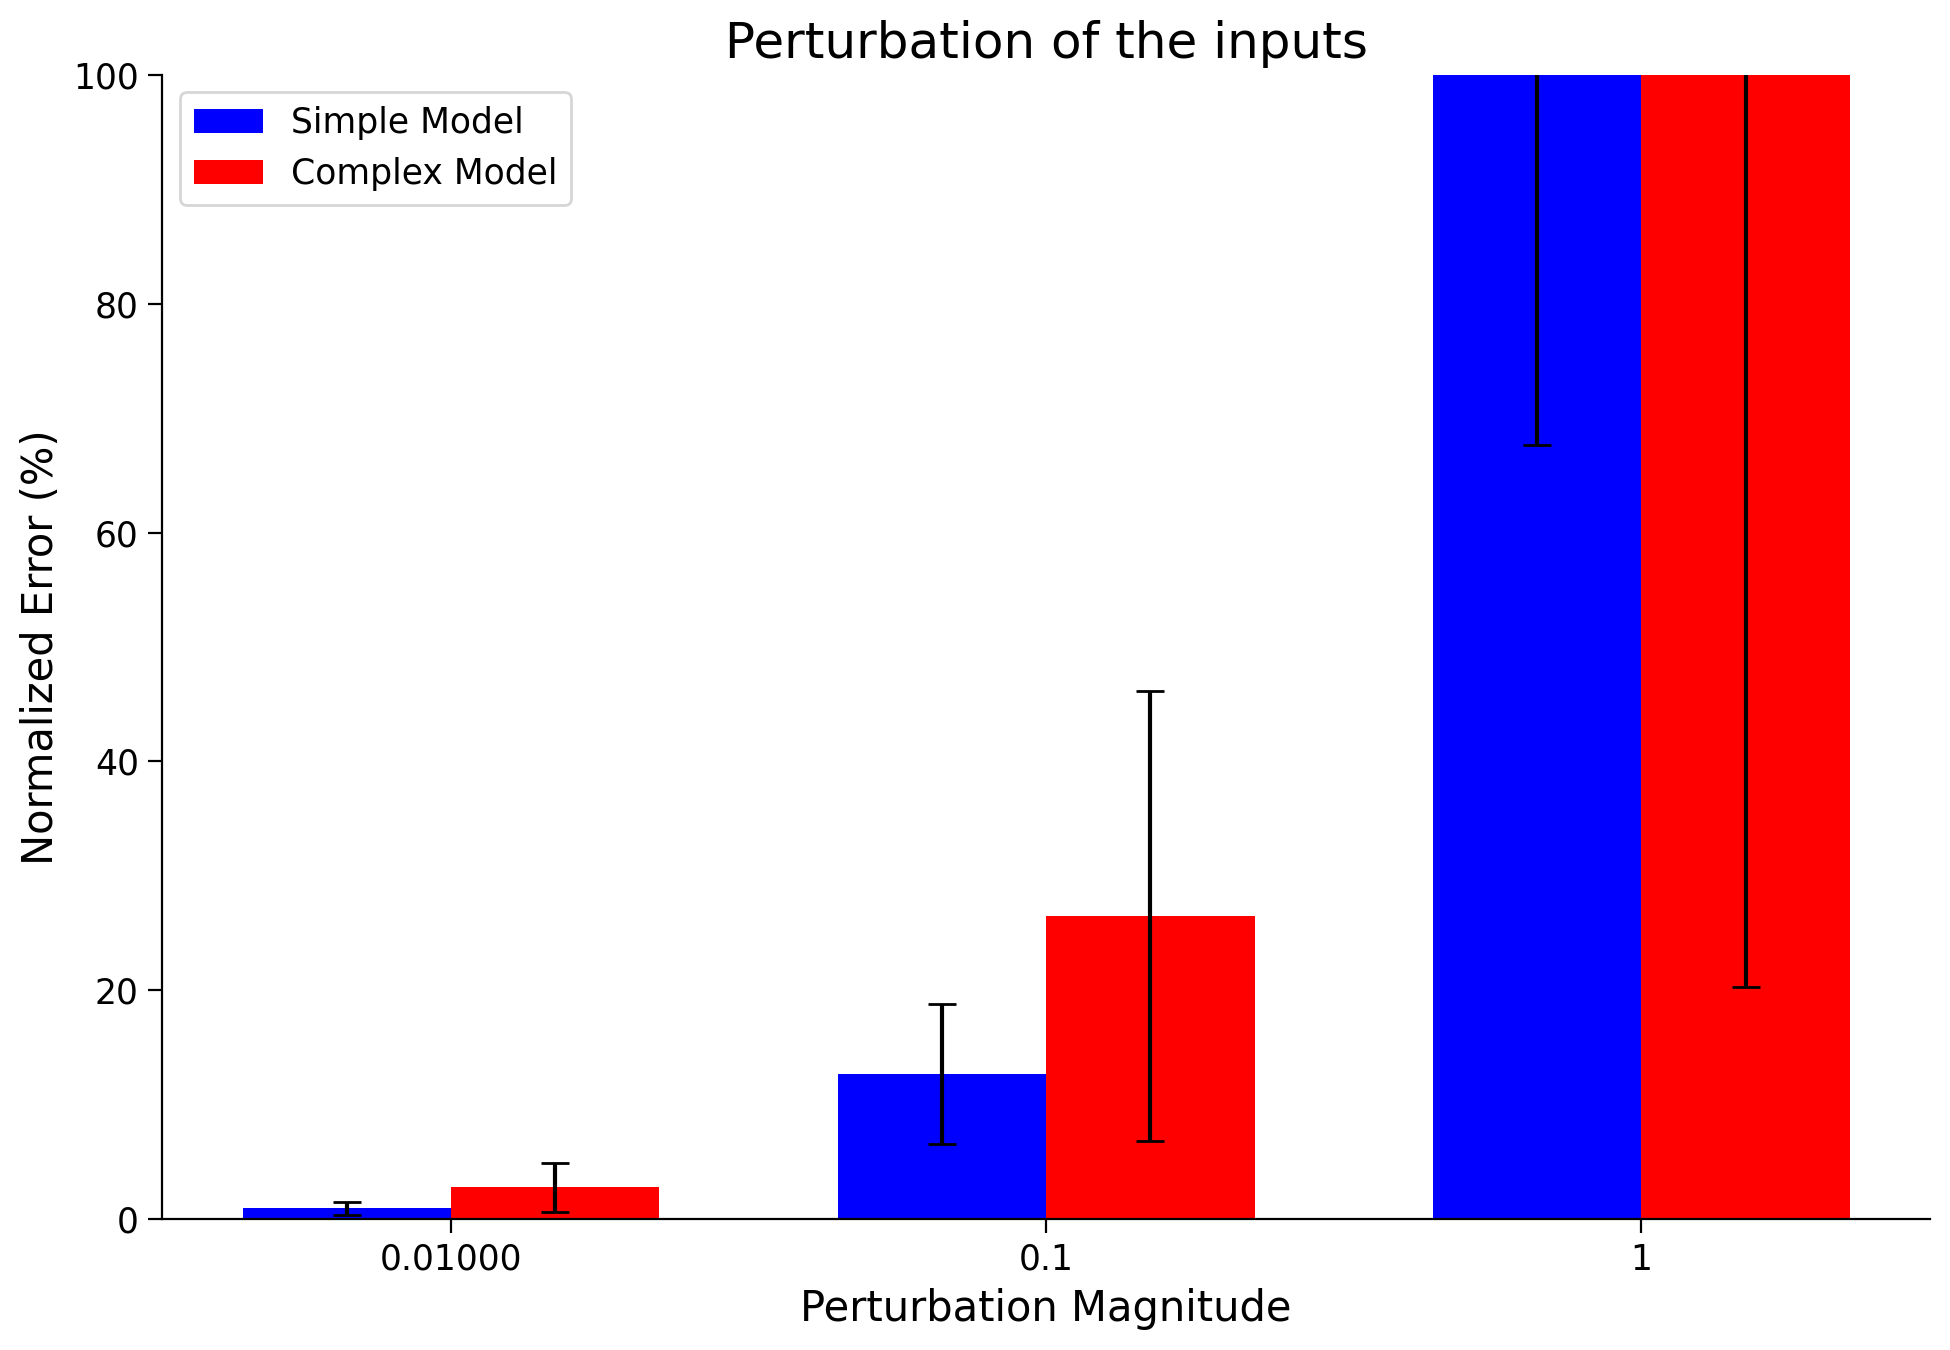

In [20]:
#Plot perturbation results
plot_perturbation_results(perturbation_strengths, results_simple, results_complex, "Perturbation of the inputs")


In [21]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader

def calculate_mean_absolute_strength(model):
    # Calculate the mean absolute connection strength of the recurrent weight matrix
    return torch.mean(torch.abs(model.J)).item()

def perturb_recurrent_weights(model, mean_strength, perturbation_percentage):
    # Perturb the recurrent weight matrix J according to a normalized percentage of the mean absolute strength
    perturbation_strength = mean_strength * perturbation_percentage
    with torch.no_grad():
        noise = torch.randn_like(model.J) * perturbation_strength
        perturbed_weights = model.J + noise
        return perturbed_weights

def test_perturbed_structure(model, perturbation_percentages, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    mean_strength = calculate_mean_absolute_strength(model)
    perturbation_results = []  # List to store (mean error, std dev) tuples

    original_weights = model.J.data.clone()  # Save the original weights

    for percentage in perturbation_percentages:
        multiple_perturbations_error = []
        print(f"Testing perturbation percentage {percentage:.4f}")
        
        for perturbation in range(30):  # Perturb 50 times for each strength
            batch_errors = []
            perturbed_weights = perturb_recurrent_weights(model, mean_strength, percentage)
            model.J.data = perturbed_weights.data
            print(f" Perturbation {perturbation+1}/50")

            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                batch_size = inputs.size(0)
                h = model.init_hidden(batch_size).to(device)
                
                for t in range(inputs.shape[1]):
                    model_output = model(inputs[:, t, :], h)
                    output, h = model_output[:2]  
                
                loss = criterion(output, targets[:, -1, :]).item()
                batch_errors.append(loss)
            
            model.J.data = original_weights.data  # Reset to original weights after each perturbation
            multiple_perturbations_error.append(np.mean(batch_errors))
        
        mean_error = np.mean(multiple_perturbations_error)  # Average over the 50 perturbations
        std_dev_error = np.std(multiple_perturbations_error)  # Standard deviation for error bars
        perturbation_results.append((mean_error, std_dev_error))
        print(f"Completed testing for perturbation percentage {percentage:.4f}. Mean error: {mean_error:.4f}, Std. dev.: {std_dev_error:.4f}\n")
    
    return perturbation_results

import time

# Start time
start_time = time.time()

# Define perturbation strengths as percentages
perturbation_strengths = [0.01, 0.1, 1]

# Function calls for simple and complex models
simple_model_errors_2 = test_perturbed_structure(model, perturbation_strengths, simple_train_loader, criterion, device)
complex_model_errors_2 = test_perturbed_structure(complicated_model, perturbation_strengths, complicated_train_loader, criterion, device)

end_time = time.time()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Testing perturbation percentage 0.0100
 Perturbation 1/50
 Perturbation 2/50
 Perturbation 3/50
 Perturbation 4/50
 Perturbation 5/50
 Perturbation 6/50
 Perturbation 7/50
 Perturbation 8/50
 Perturbation 9/50
 Perturbation 10/50
 Perturbation 11/50
 Perturbation 12/50
 Perturbation 13/50
 Perturbation 14/50
 Perturbation 15/50
 Perturbation 16/50
 Perturbation 17/50
 Perturbation 18/50
 Perturbation 19/50
 Perturbation 20/50
 Perturbation 21/50
 Perturbation 22/50
 Perturbation 23/50
 Perturbation 24/50
 Perturbation 25/50
 Perturbation 26/50
 Perturbation 27/50
 Perturbation 28/50
 Perturbation 29/50
 Perturbation 30/50
Completed testing for perturbation percentage 0.0100. Mean error: 0.0002, Std. dev.: 0.0000

Testing perturbation percentage 0.1000
 Perturbation 1/50
 Perturbation 2/50
 Perturbation 3/50
 Perturbation 4/50
 Perturbation 5/50
 Perturbation 6/50
 Perturbation 7/50
 Perturbation 8/50
 Perturbation 9/50
 Perturbation 10/50
 Perturbation 11/50
 Perturbation 12/50
 Pertur

SimpleRNN: mean errors (0.00023198927160895738, 0.0005413032603488924, 0.017139380235845846)
ComplicatedRNN: mean errors (0.000294553984056356, 0.001305846584685355, 0.04982429444928584)
SimpleRNN: normalised mean errors [1.3535452765308726, 3.158242905521132, 100.0]
ComplicatedRNN: normalised mean errors [0.5911854594472397, 2.6209033145758323, 100.0]


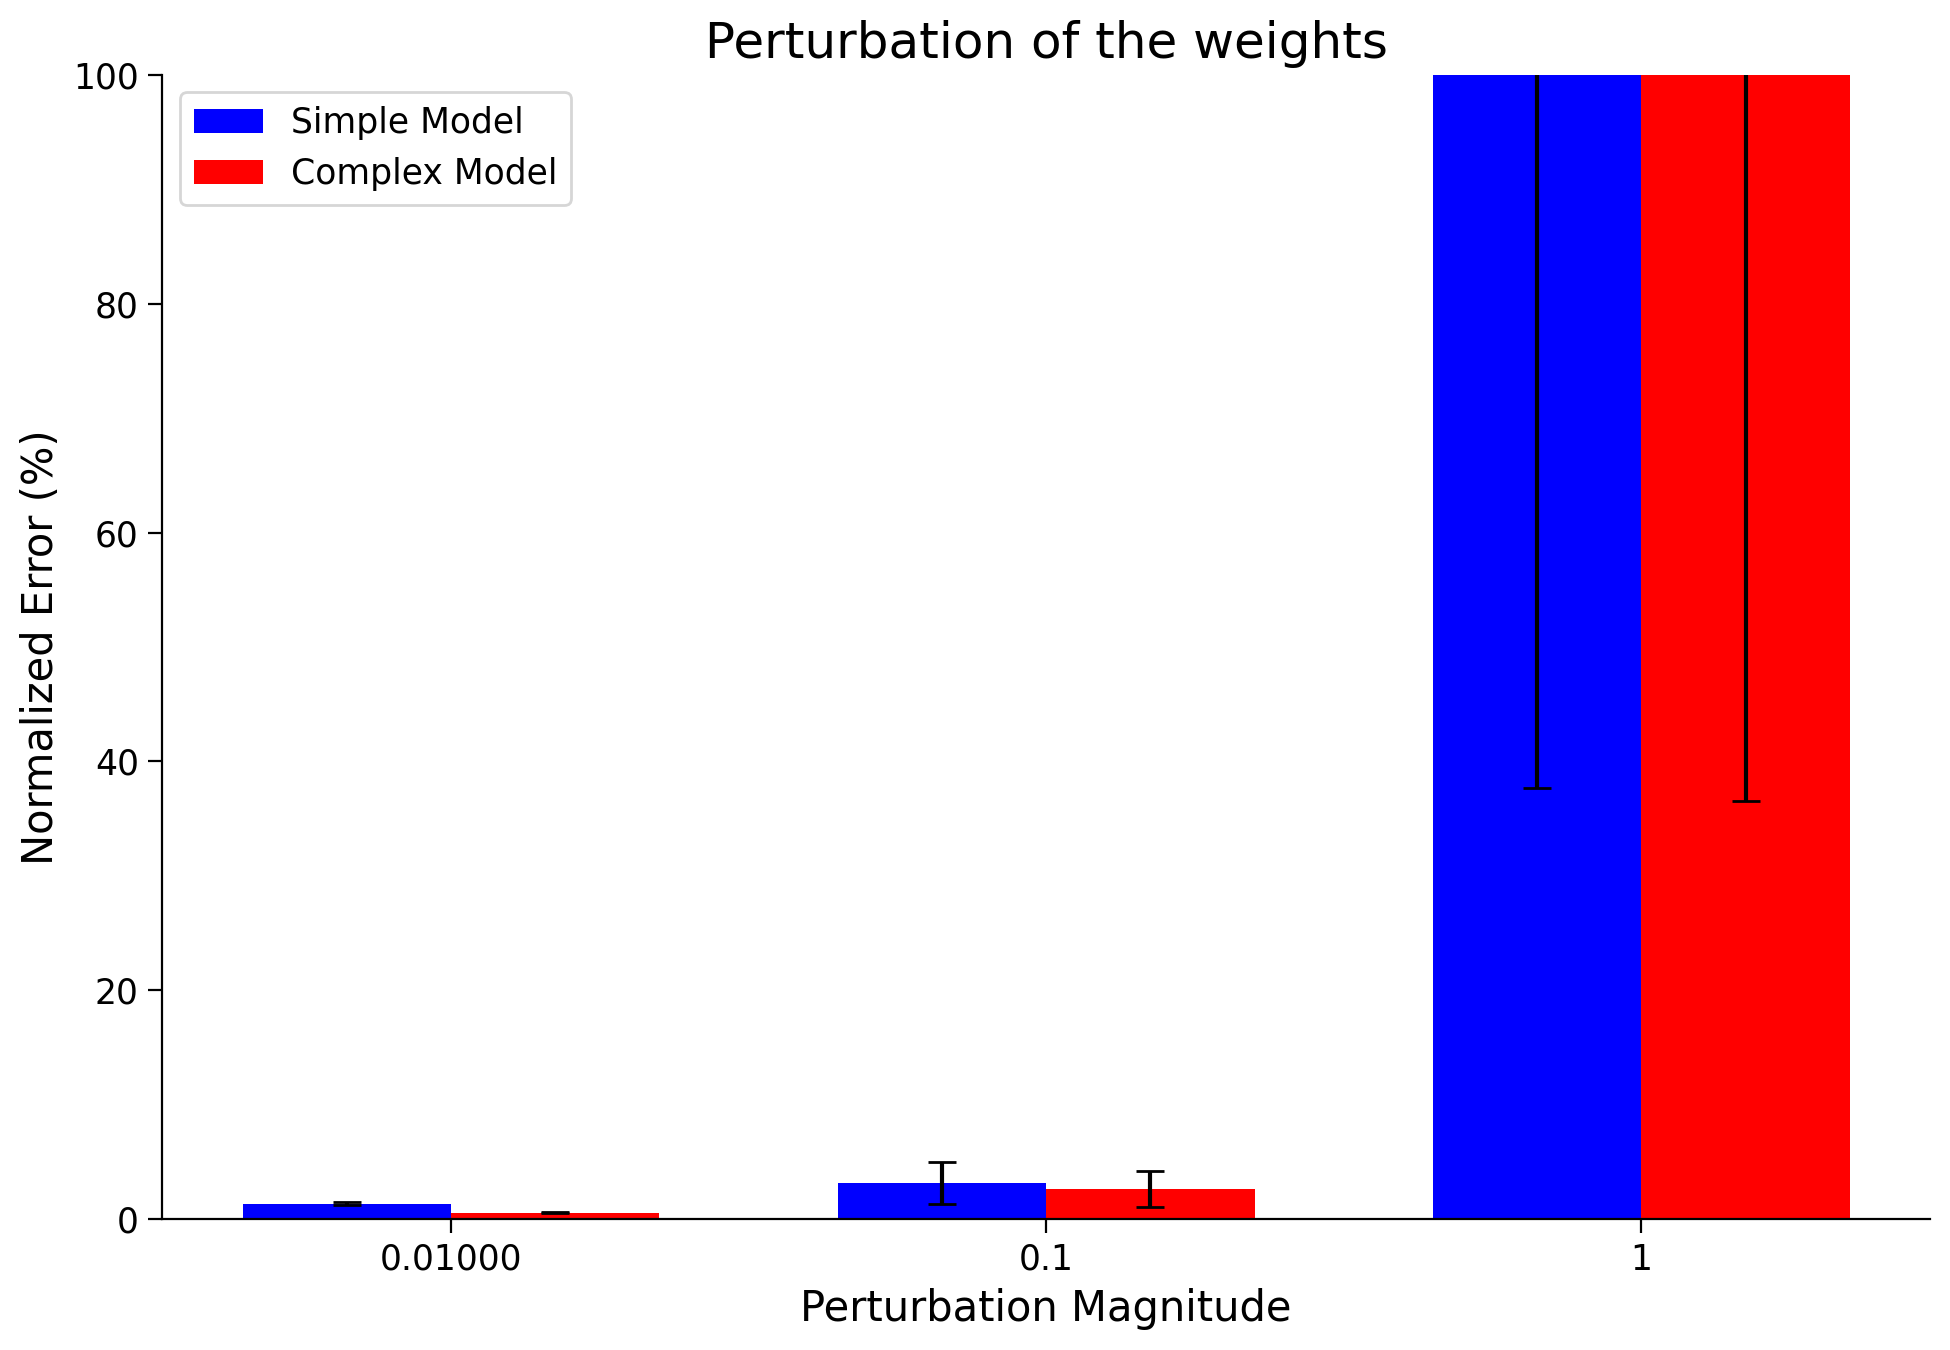

In [22]:
#Plot perturbation results
plot_perturbation_results(perturbation_strengths, simple_model_errors_2, complex_model_errors_2, "Perturbation of the weights")
